# Historical Hourly Weather Data: audit, preprocess, and task setup

I load the Kaggle historical hourly weather dataset, run a quick data audit, reshape to a tidy city-level panel, save Parquet files, and define two forecasting tasks:
- Task A: single-city hourly temperature forecasting
- Task B: multi-city transfer learning



Data Source: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data/

##1. Imports and options

In [ ]:
#standard scientific Python packages
import os, glob, zipfile, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)


##2. Load the zip and list files

In [ ]:
# Set these paths for my Colab session
ZIP_PATH = "/content/archive_.zip"    # change to my uploaded filename in Colab
RAW_DIR  = "/content/hhw_raw"

# Extract if needed
if os.path.exists(ZIP_PATH) and not os.path.exists(RAW_DIR):
    os.makedirs(RAW_DIR, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(RAW_DIR)

# Inspect what is inside
all_files = sorted(glob.glob(os.path.join(RAW_DIR, "*.csv")))
all_files[:10], len(all_files)


(['/content/hhw_raw/city_attributes.csv',
  '/content/hhw_raw/humidity.csv',
  '/content/hhw_raw/pressure.csv',
  '/content/hhw_raw/temperature.csv',
  '/content/hhw_raw/weather_description.csv',
  '/content/hhw_raw/wind_direction.csv',
  '/content/hhw_raw/wind_speed.csv'],
 7)

##3. Helper to read variable file and convert to long format

In [ ]:
def read_wide_csv_to_long(path, var_name):
    df = pd.read_csv(path)
    # Standardize the datetime column name
    dt_col = [c for c in df.columns if "datetime" in c.lower()]
    assert len(dt_col) == 1, "Cannot find a unique datetime column"
    dt_col = dt_col[0]
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
    # Melt to long format
    long_df = df.melt(id_vars=[dt_col], var_name="city", value_name=var_name)
    long_df = long_df.rename(columns={dt_col: "datetime"})
    # Sort and drop obvious empties
    long_df = long_df.dropna(subset=["datetime"]).sort_values(["city", "datetime"]).reset_index(drop=True)
    return long_df


##4. Load variables and merge to a tidy panel

In [ ]:
# Map file names to my standardized variable names
name_map = {
    "temperature": "temp_c",
    "humidity": "humidity",
    "pressure": "pressure_hpa",
    "wind_speed": "wind_speed_ms",
    "wind_direction": "wind_deg",
    "weather_description": "weather_desc"
}

long_parts = []
for path in all_files:
    base = os.path.splitext(os.path.basename(path))[0].lower()
    # find the key by prefix match
    key = None
    for k in name_map:
        if base.startswith(k):
            key = k
            break
    if key is None:
        continue
    var = name_map[key]
    part = read_wide_csv_to_long(path, var)
    long_parts.append(part)

# Merge on datetime and city
from functools import reduce
panel = reduce(lambda left, right: pd.merge(left, right, on=["datetime","city"], how="outer"), long_parts)

# Basic cleaning
panel = panel.drop_duplicates(subset=["datetime","city"]).sort_values(["city","datetime"]).reset_index(drop=True)

panel.head()


,datetime,city,humidity,pressure_hpa,temp_c,weather_desc,wind_deg,wind_speed_ms
0,2012-10-01 12:00:00,Albuquerque,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,Albuquerque,50.0,1024.0,285.120000,sky is clear,360.0,4.0
2,2012-10-01 14:00:00,Albuquerque,49.0,1024.0,285.154558,sky is clear,360.0,4.0
3,2012-10-01 15:00:00,Albuquerque,49.0,1024.0,285.233952,sky is clear,360.0,4.0
4,2012-10-01 16:00:00,Albuquerque,49.0,1024.0,285.313345,sky is clear,360.0,4.0


##5. Time hygiene and indexing

In [ ]:
# Add simple calendar features
panel["year"] = panel["datetime"].dt.year
panel["month"] = panel["datetime"].dt.month
panel["day"] = panel["datetime"].dt.day
panel["hour"] = panel["datetime"].dt.hour
panel["doy"]  = panel["datetime"].dt.dayofyear

# Keep a copy with a multiindex for some operations
panel_idx = panel.set_index(["city","datetime"]).sort_index()
panel_idx.head()


humidity  pressure_hpa      temp_c  \
city        datetime                                                  
Albuquerque 2012-10-01 12:00:00       NaN           NaN         NaN   
            2012-10-01 13:00:00      50.0        1024.0  285.120000   
            2012-10-01 14:00:00      49.0        1024.0  285.154558   
            2012-10-01 15:00:00      49.0        1024.0  285.233952   
            2012-10-01 16:00:00      49.0        1024.0  285.313345   

                                 weather_desc  wind_deg  wind_speed_ms  year  \
city        datetime                                                           
Albuquerque 2012-10-01 12:00:00           NaN       NaN            NaN  2012   
            2012-10-01 13:00:00  sky is clear     360.0            4.0  2012   
            2012-10-01 14:00:00  sky is clear     360.0            4.0  2012   
            2012-10-01 15:00:00  sky is clear     360.0            4.0  2012   
            2012-10-01 16:00:00  sky is clear     360.0            4.0  2012   

                                 month  day  hour  doy  
city        datetime                                    
Albuquerque 2012-10-01 12:00:00     10    1    12  275  
            2012-10-01 13:00:00     10    1    13  275  
            2012-10-01 14:00:00     10    1    14  275  
            2012-10-01 15:00:00     10    1    15  275  
            2012-10-01 16:00:00     10    1    16  275

##6. Quick data audit

#6.1 Coverage and date ranges by city

In [ ]:
def coverage_summary(df_idx, target_col="temp_c"):
    grp = df_idx.reset_index().groupby("city")
    out = grp.agg(
        start=("datetime", "min"),
        end=("datetime","max"),
        n_rows=("datetime","size"),
        n_temp=(target_col, lambda x: x.notna().sum()),
        miss_temp=(target_col, lambda x: x.isna().sum())
    ).reset_index()
    out["pct_missing_temp"] = 100.0 * out["miss_temp"] / out["n_rows"]
    return out.sort_values("city")

coverage = coverage_summary(panel_idx)
coverage.head(10)


,city,start,end,n_rows,n_temp,miss_temp,pct_missing_temp
0,Albuquerque,2012-10-01 12:00:00,2017-11-30,45253,45252,1,0.002210
1,Atlanta,2012-10-01 12:00:00,2017-11-30,45253,45247,6,0.013259
2,Beersheba,2012-10-01 12:00:00,2017-11-30,45253,44455,798,1.763419
3,Boston,2012-10-01 12:00:00,2017-11-30,45253,45250,3,0.006629
4,Charlotte,2012-10-01 12:00:00,2017-11-30,45253,45250,3,0.006629
5,Chicago,2012-10-01 12:00:00,2017-11-30,45253,45250,3,0.006629
6,Dallas,2012-10-01 12:00:00,2017-11-30,45253,45249,4,0.008839
7,Denver,2012-10-01 12:00:00,2017-11-30,45253,45252,1,0.002210
8,Detroit,2012-10-01 12:00:00,2017-11-30,45253,45252,1,0.002210
9,Eilat,2012-10-01 12:00:00,2017-11-30,45253,44461,792,1.750160


#6.2 Missingness by variabe

In [16]:
def missingness_by_var(df_idx):
    cols = [c for c in df_idx.columns if c not in ["year","month","day","hour","doy"]]
    rows = []
    for c in cols:
        s = df_idx[c]
        rows.append({
            "variable": c,
            "non_null": int(s.notna().sum()),
            "nulls": int(s.isna().sum()),
            "pct_missing": 100.0 * s.isna().mean()
        })
    return pd.DataFrame(rows).sort_values("pct_missing", ascending=False)

missing_table = missingness_by_var(panel_idx)
missing_table


,variable,non_null,nulls,pct_missing
0,humidity,1600457,28651,1.758692
1,pressure_hpa,1612428,16680,1.023873
2,temp_c,1621078,8030,0.492908
5,wind_speed_ms,1621115,7993,0.490637
4,wind_deg,1621133,7975,0.489532
3,weather_desc,1621153,7955,0.488304


#6.3 Simple sanity plots

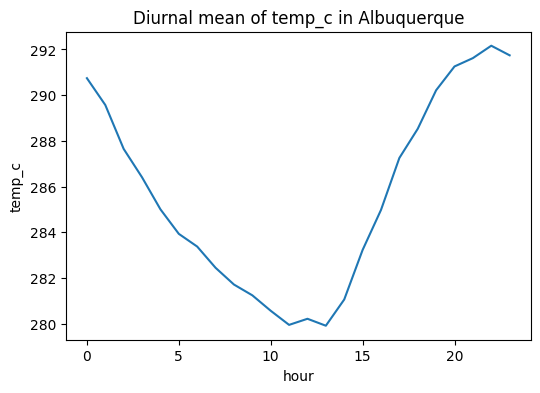

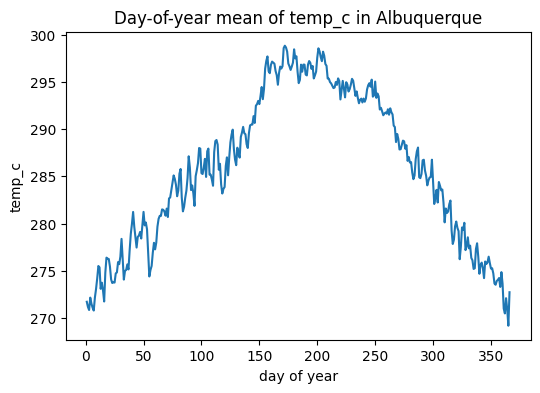

In [ ]:
def plot_diurnal(df_idx, city, var="temp_c"):
    s = df_idx.loc[city][[var]].copy()
    s["hour"] = s.index.get_level_values("datetime").hour
    tmp = s.groupby("hour")[var].mean().reset_index()
    plt.figure(figsize=(6,4))
    plt.plot(tmp["hour"], tmp[var])
    plt.title(f"Diurnal mean of {var} in {city}")
    plt.xlabel("hour")
    plt.ylabel(var)
    plt.show()

def plot_annual(df_idx, city, var="temp_c"):
    s = df_idx.loc[city][[var]].copy()
    s["doy"] = s.index.get_level_values("datetime").dayofyear
    tmp = s.groupby("doy")[var].mean().reset_index()
    plt.figure(figsize=(6,4))
    plt.plot(tmp["doy"], tmp[var])
    plt.title(f"Day-of-year mean of {var} in {city}")
    plt.xlabel("day of year")
    plt.ylabel(var)
    plt.show()

some_city = coverage["city"].iloc[0] if len(coverage) else None
if some_city:
    plot_diurnal(panel_idx, some_city)
    plot_annual(panel_idx, some_city)


##7. Save tidy Parquet per city

In [ ]:
PROCESSED_DIR = "/content/hhw_processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Save one Parquet per city
for city in coverage["city"].tolist():
    cdf = panel_idx.loc[city].reset_index()
    cdf.to_parquet(os.path.join(PROCESSED_DIR, f"{city}.parquet"), index=False)

# Write a short data card
card = []
card.append("# Data card")
card.append("")
card.append("This folder contains one Parquet file per city, with hourly rows.")
card.append("")
card.append("Columns: datetime, temp_c, humidity, pressure_hpa, wind_speed_ms, wind_deg, weather_desc, year, month, day, hour, doy.")
card.append("")
card.append("I created these from the Kaggle historical hourly weather dataset.")
card.append("")
with open(os.path.join(PROCESSED_DIR, "DATA_CARD.md"), "w") as f:
    f.write("\n".join(card))

len(os.listdir(PROCESSED_DIR)), os.listdir(PROCESSED_DIR)[:5]


(37,
 ['Haifa.parquet',
  'Phoenix.parquet',
  'Montreal.parquet',
  'Seattle.parquet',
  'Nashville.parquet'])

##8. Split into two tasks: Task A and Task B
-Task A: single city, rolling origin.
-Task B: train on many cities, test on held out cities.

In [ ]:
from typing import Tuple, List, Dict

def rolling_time_splits(df_city, val_year=2016, test_year=2017):
    train = df_city[df_city["datetime"].dt.year < val_year]
    val   = df_city[df_city["datetime"].dt.year == val_year]
    test  = df_city[df_city["datetime"].dt.year == test_year]
    return train, val, test

def load_city(city)->pd.DataFrame:
    return pd.read_parquet(os.path.join(PROCESSED_DIR, f"{city}.parquet"))

# Task A example
if some_city:
    dfc = load_city(some_city)
    train, val, test = rolling_time_splits(dfc, val_year=2016, test_year=2017)
    for name, d in [("train",train),("val",val),("test",test)]:
        print(name, d["datetime"].min(), d["datetime"].max(), len(d))

# Task B: split cities
def split_cities(cities: List[str], n_train:int=24) -> Tuple[List[str], List[str]]:
    cities_sorted = sorted(cities)
    train_cities = cities_sorted[:n_train]
    test_cities  = cities_sorted[n_train:]
    return train_cities, test_cities

all_cities = coverage["city"].tolist()
train_cities, test_cities = split_cities(all_cities, n_train=min(24, len(all_cities)//2))
train_cities[:5], test_cities[:5]


train 2012-10-01 12:00:00 2015-12-31 23:00:00 28476
val 2016-01-01 00:00:00 2016-12-31 23:00:00 8784
test 2017-01-01 00:00:00 2017-11-30 00:00:00 7993


(['Albuquerque', 'Atlanta', 'Beersheba', 'Boston', 'Charlotte'],
 ['Miami', 'Minneapolis', 'Montreal', 'Nahariyya', 'Nashville'])

##9. Baselines for Task A

I set two quick baselines: persistence and seasonal naive (diurnal plus day-of-year mean). These give me a sanity lower bound before I plug in my BEKF work.

In [ ]:
def persistence_forecast(series: pd.Series, horizon: int) -> pd.Series:
    # Forecast at t+h equals observed at t
    return series.shift(0).shift(0).reindex(series.index).shift(0).shift(horizon)

def seasonal_naive(df_city: pd.DataFrame, horizon: int, var="temp_c") -> pd.Series:
    # Use hour of day and day of year means as a seasonal profile
    prof = df_city.groupby(["doy","hour"])[var].mean()
    idx = list(zip(df_city["doy"].values, df_city["hour"].values))
    base = pd.Series([prof.get(t, np.nan) for t in idx], index=df_city.index)
    return base.shift(horizon)

def rmse(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum()==0:
        return np.nan
    return float(np.sqrt(np.mean((y_true[m]-y_pred[m])**2)))

if some_city:
    dfc = load_city(some_city).dropna(subset=["temp_c"])
    dfc = dfc.set_index("datetime").sort_index()
    y = dfc["temp_c"].copy()
    horizon = 6   # 6 hour ahead for a quick check

    yhat_pers = persistence_forecast(y, horizon)
    yhat_seas = seasonal_naive(dfc.reset_index(), horizon, var="temp_c").set_axis(y.index)

    print("RMSE 6h ahead, persistence:", rmse(y, yhat_pers))
    print("RMSE 6h ahead, seasonal naive:", rmse(y, yhat_seas))


RMSE 6h ahead, persistence: 6.821672842715511
RMSE 6h ahead, seasonal naive: 7.325560034644878


FilterPy is handy for linear algebra routines and sanity checks



In [ ]:
!pip -q install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


##10. Write helper modules

In [ ]:
# This cell creates metrics.py, enkf_student_t.py, and hooks.py in /content

from pathlib import Path

metrics_py = r'''
import numpy as np
import pandas as pd
from scipy.stats import norm
from numpy.typing import ArrayLike

def crps_gaussian(y: ArrayLike, mu: ArrayLike, sigma: ArrayLike) -> float:
    """Closed-form CRPS for a univariate Gaussian N(mu, sigma^2).
    Returns mean CRPS over all finite triplets."""
    y = np.asarray(y, float)
    mu = np.asarray(mu, float)
    sigma = np.asarray(sigma, float)
    m = np.isfinite(y) & np.isfinite(mu) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(m):
        return np.nan
    z = (y[m] - mu[m]) / sigma[m]
    phi = norm.pdf(z)
    Phi = norm.cdf(z)
    crps = sigma[m] * (z * (2 * Phi - 1) + 2 * phi - 1 / np.sqrt(np.pi))
    return float(np.mean(crps))

def crps_from_samples(y: ArrayLike, samples: ArrayLike) -> float:
    """Sample CRPS estimate: E|X - y| - 0.5 E|X - X'|.
    samples shape can be [n_samples, n_times] or [n_times, n_samples].
    Returns mean over times with finite y."""
    y = np.asarray(y, float)
    S = np.asarray(samples, float)
    if S.shape[0] < S.shape[1]:
        S = S.T
    T, Snum = S.shape
    m = np.isfinite(y[:T])
    if not np.any(m):
        return np.nan
    yv = y[:T][m][:, None]
    S_m = S[m]
    term1 = np.mean(np.abs(S_m - yv))
    diff = np.abs(S_m[:, :, None] - S_m[:, None, :])
    term2 = 0.5 * np.mean(diff)
    return float(term1 - term2)

def pit_from_samples(y: ArrayLike, samples: ArrayLike) -> np.ndarray:
    """PIT using the empirical CDF from samples."""
    y = np.asarray(y, float)
    S = np.asarray(samples, float)
    if S.shape[0] < S.shape[1]:
        S = S.T
    T = S.shape[0]
    m = np.isfinite(y[:T])
    pits = np.full(T, np.nan)
    yv = y[:T][m]
    ranks = np.sum(S[m] <= yv[:, None], axis=1)
    pits[m] = (ranks + 0.5) / (S.shape[1] + 1.0)
    return pits

def reliability_curve(y: ArrayLike, q_forecasts: dict, qs=None) -> pd.DataFrame:
    """Reliability curve for quantiles. q_forecasts like {0.1: q10, ...}."""
    if qs is None:
        qs = sorted(q_forecasts.keys())
    rows = []
    y = np.asarray(y, float)
    for q in qs:
        qv = np.asarray(q_forecasts[q], float)
        m = np.isfinite(y) & np.isfinite(qv)
        if not np.any(m):
            rows.append({"q": q, "empirical": np.nan, "n": 0})
            continue
        hits = np.mean(y[m] <= qv[m])
        rows.append({"q": q, "empirical": float(hits), "n": int(np.sum(m))})
    return pd.DataFrame(rows)

def diebold_mariano(loss_a: ArrayLike, loss_b: ArrayLike, h: int = 1) -> dict:
    """DM test for equal predictive accuracy with Newey West variance."""
    from scipy.stats import norm
    la = np.asarray(loss_a, float)
    lb = np.asarray(loss_b, float)
    m = np.isfinite(la) & np.isfinite(lb)
    d = la[m] - lb[m]
    T = len(d)
    if T < 5:
        return {"DM": np.nan, "p": np.nan, "T": T}
    def newey_west_var(x, L):
        x = x - np.mean(x)
        gamma0 = np.sum(x * x) / T
        s = gamma0
        for l in range(1, L + 1):
            w = 1 - l / (L + 1)
            gamma = np.sum(x[l:] * x[:-l]) / T
            s += 2 * w * gamma
        return s
    L = max(h - 1, 1)
    var = newey_west_var(d, L)
    dm = np.mean(d) / np.sqrt(var / T)
    p = 2 * (1 - norm.cdf(np.abs(dm)))
    return {"DM": float(dm), "p": float(p), "T": T}
'''

enkf_student_t_py = r'''
import numpy as np
from numpy.linalg import inv

def _ens_mean_cov(X):
    """X shape [state_dim, N]. Returns mean, covariance, anomalies."""
    m = np.mean(X, axis=1, keepdims=True)
    A = X - m
    P = (A @ A.T) / (X.shape[1] - 1)
    return m, P, A

def inflate_ensemble(Xf, alpha):
    """Multiply ensemble anomalies by sqrt(alpha)."""
    m, _, _ = _ens_mean_cov(Xf)
    return m + np.sqrt(alpha) * (Xf - m)

def kalman_gain_from_ensembles(Xf, Yf, R):
    """Cross cov Pxy and innovation cov S from ensembles, then K."""
    _, _, Axf = _ens_mean_cov(Xf)
    _, Pyy, Ayf = _ens_mean_cov(Yf)
    Pxy = (Axf @ Ayf.T) / (Xf.shape[1] - 1)
    S = Pyy + R
    K = Pxy @ inv(S)
    return K, S

def student_t_scale_weight(innov, S, nu, m_obs):
    """Posterior mean of scale variable for Student t."""
    md2 = float(innov.T @ inv(S) @ innov)
    w_hat = (nu + m_obs) / (nu + md2)
    return max(w_hat, 1e-6)

def enkf_update_student_t(Xf, y_obs, h_func, R, nu=5.0, obs_perturb=True):
    """
    EnKF update with Student t observation noise via scale mixture.
    Xf shape [nx, N]
    y_obs shape [ny]
    h_func maps state particles to obs space and returns [ny, N]
    R is base observation covariance
    """
    nx, N = Xf.shape
    y_obs = np.asarray(y_obs).reshape(-1, 1)
    Yf = h_func(Xf)
    ny = Yf.shape[0]
    y_mean = np.mean(Yf, axis=1, keepdims=True)
    innov = y_obs - y_mean
    _, Pyy, _ = _ens_mean_cov(Yf)
    S0 = Pyy + R
    w_hat = student_t_scale_weight(innov, S0, nu, ny)
    R_eff = R / w_hat
    K, S = kalman_gain_from_ensembles(Xf, Yf, R_eff)
    if obs_perturb:
        eps = np.random.multivariate_normal(mean=np.zeros(ny), cov=R_eff, size=N).T
        Yo = y_obs + eps
        Xa = Xf + K @ (Yo - Yf)
    else:
        Xa = Xf + K @ (y_obs - Yf)
    info = {"K": K, "S": S, "w_hat": float(w_hat)}
    return Xa, info

def choose_scalar_inflation(Xf_hist, y_hist, h_func, R, nu=5.0, alphas=None):
    """
    Pick scalar inflation by minimizing rolling predictive negative log likelihood.
    Xf_hist is a list of ensembles
    y_hist is a list of obs vectors
    """
    if alphas is None:
        alphas = np.linspace(1.0, 1.5, 11)
    def nll_for_alpha(alpha):
        ll = []
        for Xf, y in zip(Xf_hist, y_hist):
            Xf_inf = inflate_ensemble(Xf, alpha)
            Yf = h_func(Xf_inf)
            y_mean = np.mean(Yf, axis=1, keepdims=True)
            _, Pyy, _ = _ens_mean_cov(Yf)
            S0 = Pyy + R
            innov = y.reshape(-1, 1) - y_mean
            w_hat = student_t_scale_weight(innov, S0, nu, Yf.shape[0])
            S = Pyy + R / w_hat
            try:
                sign, logdet = np.linalg.slogdet(S)
                if sign <= 0:
                    return np.inf
                md2 = float(innov.T @ inv(S) @ innov)
                ll.append(0.5 * (logdet + md2))
            except np.linalg.LinAlgError:
                return np.inf
        return float(np.mean(ll)) if ll else np.inf
    rows = []
    best_alpha = None
    best_val = np.inf
    for a in alphas:
        val = nll_for_alpha(a)
        rows.append((a, val))
        if val < best_val:
            best_alpha, best_val = a, val
    import pandas as pd
    table = pd.DataFrame(rows, columns=["alpha", "avg_nll"]).sort_values("alpha")
    return float(best_alpha), table
'''

hooks_py = r'''
import numpy as np

def f_identity(X):
    """Identity dynamics with small Gaussian process noise."""
    nx, N = X.shape
    Q = 0.05 * np.eye(nx)
    noise = np.random.multivariate_normal(np.zeros(nx), Q, size=N).T
    return X + noise

def h_linear(X):
    """Observation function. First state is temperature."""
    return X[:1, :]
'''

Path("metrics.py").write_text(metrics_py)
Path("enkf_student_t.py").write_text(enkf_student_t_py)
Path("hooks.py").write_text(hooks_py)

print("Wrote files:", [p.name for p in Path('.').glob('*.py')])


Wrote files: ['enkf_student_t.py', 'metrics.py', 'hooks.py']


In [17]:
# I run this once after writing metrics.py, enkf_student_t.py, and hooks.py

import os, sys, importlib

# 1) Make sure I am in /content (where the files were written)
print("cwd before:", os.getcwd())
if "/content" not in os.getcwd():
    os.chdir("/content")
print("cwd after:", os.getcwd())

# 2) Ensure /content is first on the import path so my local files win
if "/content" not in sys.path:
    sys.path.insert(0, "/content")
else:
    # move it to front if needed
    sys.path = [p for p in sys.path if p != "/content"]
    sys.path.insert(0, "/content")

# 3) Clear import caches so Python sees freshly created files
importlib.invalidate_caches()

# 4) Avoid variable name collisions from earlier cells
for name in ["metrics", "enkf_student_t", "hooks"]:
    if name in globals() and not hasattr(globals()[name], "__file__"):
        del globals()[name]

# 5) Import and print module file paths to confirm
import metrics, enkf_student_t, hooks
importlib.reload(metrics)
importlib.reload(enkf_student_t)
importlib.reload(hooks)

print("metrics ->", metrics.__file__)
print("enkf_student_t ->", enkf_student_t.__file__)
print("hooks ->", hooks.__file__)

# 6) Pull the exact symbols I need
from enkf_student_t import enkf_update_student_t, inflate_ensemble, choose_scalar_inflation
from hooks import f_identity, h_linear
from metrics import crps_from_samples, pit_from_samples, reliability_curve, diebold_mariano

print("Imports ready.")


cwd before: /content
cwd after: /content
metrics -> /content/metrics.py
enkf_student_t -> /content/enkf_student_t.py
hooks -> /content/hooks.py
Imports ready.


## 11. Import and run the Task A demo

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from enkf_student_t import enkf_update_student_t, inflate_ensemble, choose_scalar_inflation
from hooks import f_identity, h_linear
from metrics import crps_from_samples, pit_from_samples, reliability_curve, diebold_mariano

PROCESSED_DIR = "/content/hhw_processed"
city = "Vancouver"
df = pd.read_parquet(f"{PROCESSED_DIR}/{city}.parquet").dropna(subset=["temp_c"])
df = df.set_index("datetime").sort_index()

This cell might take a while to run

Mean CRPS (Gaussian approx, stride=3): 2.4440


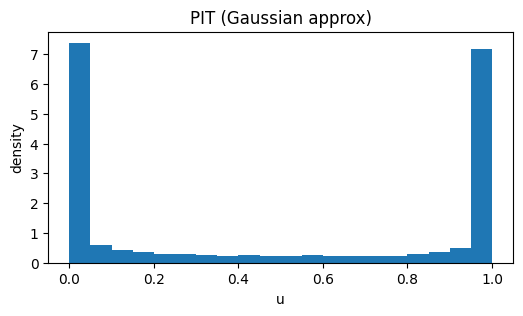

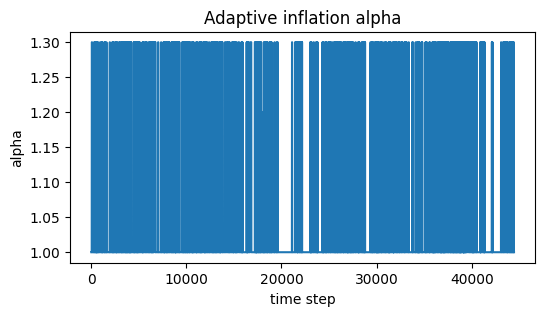

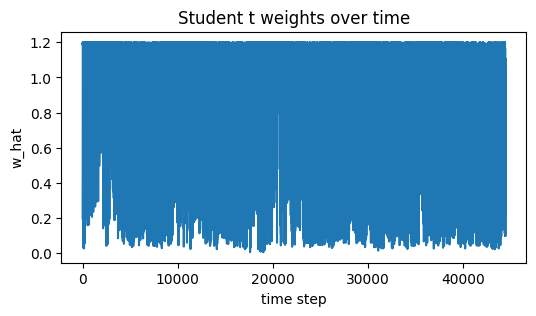

In [21]:
from metrics import crps_gaussian  # I will use the Gaussian closed-form

h = 6
y = df["temp_c"].values
times = df.index.to_list()
T = len(times)

# Speed-friendly settings
N = 20                 # smaller ensemble while prototyping
R = np.array([[0.5 ** 2]])
nu = 5.0
window = 24            # rolling window for alpha
alpha_grid = np.array([1.0, 1.1, 1.2, 1.3])  # smaller grid
alpha_every = 6        # re-tune alpha every 6 steps
eval_stride = 3        # only record a forecast every 3 steps

X = np.random.normal(loc=y[0], scale=0.8, size=(N,)).reshape(1, N)

alphas = []
w_hats = []
mu_list = []           # store Gaussian mu for CRPS approx
sigma_list = []        # store Gaussian sigma for CRPS approx
y_eval = []
idx_eval = []

Xf_hist = []
y_hist = []
alpha = 1.0            # current inflation

for t in range(1, T - h):
    # Forecast to time t
    Xf = f_identity(X)

    # Update rolling window buffers
    Xf_hist.append(Xf.copy())
    y_hist.append(np.array([y[t]]))
    if len(Xf_hist) > window:
        Xf_hist.pop(0)
        y_hist.pop(0)

    # Re-tune alpha every alpha_every steps, else reuse last alpha
    if (t % alpha_every == 0) and (len(Xf_hist) >= max(8, window//2)):
        alpha, _ = choose_scalar_inflation(Xf_hist, y_hist, h_linear, R, nu=nu, alphas=alpha_grid)
    alphas.append(alpha)

    # Inflate and update with Student t
    Xf = inflate_ensemble(Xf, alpha)
    Xa_t, info = enkf_update_student_t(Xf, np.array([y[t]]), h_linear, R, nu=nu, obs_perturb=True)
    w_hats.append(info["w_hat"])

    # Only compute and store an h-step forecast every eval_stride steps
    if t % eval_stride == 0:
        Xh = Xa_t.copy()
        for _ in range(h):
            Xh = f_identity(Xh)
        yh_samples = h_linear(Xh).flatten()
        mu_list.append(float(np.mean(yh_samples)))
        sigma_list.append(float(np.std(yh_samples, ddof=1) + 1e-6))
        y_eval.append(float(y[t + h]))
        idx_eval.append(times[t + h])

    # Advance analysis
    X = Xa_t

# Turn lists into arrays for scoring
y_eval = np.array(y_eval)
mu = np.array(mu_list)
sigma = np.array(sigma_list)

# CRPS using Gaussian closed-form from the sample mean and std
crps_vals = []
for i in range(len(y_eval)):
    crps_vals.append(crps_gaussian(y_eval[i], mu[i], sigma[i]))
mean_crps = float(np.nanmean(crps_vals))
print("Mean CRPS (Gaussian approx, stride={}): {:.4f}".format(eval_stride, mean_crps))

# Optional: approximate PIT from Gaussian CDF
from scipy.stats import norm
pits = norm.cdf((y_eval - mu) / sigma)
plt.figure(figsize=(6, 3))
plt.hist(pits[np.isfinite(pits)], bins=20, density=True)
plt.title("PIT (Gaussian approx)")
plt.xlabel("u"); plt.ylabel("density")
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(alphas)
plt.title("Adaptive inflation alpha")
plt.xlabel("time step"); plt.ylabel("alpha")
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(w_hats)
plt.title("Student t weights over time")
plt.xlabel("time step"); plt.ylabel("w_hat")
plt.show()


##12. Create helper file for Koopman lift

In [22]:
from pathlib import Path
import textwrap

koopman_edmd_py = r'''
import numpy as np
from itertools import combinations_with_replacement

class EDMD:
    """
    Extended Dynamic Mode Decomposition with either polynomial or random Fourier features.
    I fit a linear map A in the lifted space and a linear readout C for the target y (temperature).
    I store feature scaling stats from the training split.
    """
    def __init__(self, kind="poly", degree=2, n_rff=256, length_scale=1.0,
                 ridge=1e-3, spectral_clip=0.99, random_state=0):
        assert kind in ("poly", "rff")
        self.kind = kind
        self.degree = int(degree)
        self.n_rff = int(n_rff)
        self.length_scale = float(length_scale)
        self.ridge = float(ridge)
        self.spectral_clip = float(spectral_clip)
        self.random_state = int(random_state)
        # fitted artifacts
        self.z_mean_ = None
        self.z_std_ = None
        self.W_ = None    # for RFF
        self.b_ = None
        self.A_ = None
        self.C_ = None
        self.K_ = None     # lifted dimension
        self._poly_exps = None

    def _standardize(self, Z):
        """Z shape [T, d]. I standardize with mean/std from train."""
        if self.z_mean_ is None:
            self.z_mean_ = np.nanmean(Z, axis=0)
            self.z_std_  = np.nanstd(Z, axis=0) + 1e-8
        return (Z - self.z_mean_) / self.z_std_

    def _build_poly_exps(self, d, deg):
        exps = [(0,)*d]
        for k in range(1, deg+1):
            for combo in combinations_with_replacement(range(d), k):
                e = [0]*d
                for idx in combo:
                    e[idx] += 1
                exps.append(tuple(e))
        return exps

    def _poly_features(self, Zs):
        """Monomials up to degree self.degree, with bias term."""
        T, d = Zs.shape
        if self._poly_exps is None:
            self._poly_exps = self._build_poly_exps(d, self.degree)
        K = len(self._poly_exps)
        Psi = np.empty((T, K), dtype=float)
        for j, e in enumerate(self._poly_exps):
            # z^e = prod_k z_k^{e_k}
            with np.errstate(over="ignore", invalid="ignore"):
                vals = np.ones(T)
                for k, p in enumerate(e):
                    if p:
                        vals *= np.power(Zs[:, k], p)
                Psi[:, j] = vals
        Psi[np.isnan(Psi)] = 0.0
        return Psi

    def _rff_init(self, d):
        rng = np.random.default_rng(self.random_state)
        self.W_ = rng.normal(loc=0.0, scale=1.0/self.length_scale, size=(d, self.n_rff))
        self.b_ = rng.uniform(0.0, 2*np.pi, size=(self.n_rff,))

    def _rff_features(self, Zs):
        if self.W_ is None or self.b_ is None:
            self._rff_init(Zs.shape[1])
        proj = Zs @ self.W_ + self.b_
        Psi = np.sqrt(2.0/self.n_rff) * np.cos(proj)
        Psi = np.hstack([np.ones((Psi.shape[0], 1)), Psi])  # bias
        return Psi

    def psi(self, Z):
        Zs = self._standardize(Z)
        if self.kind == "poly":
            return self._poly_features(Zs)
        else:
            return self._rff_features(Zs)

    def _ridge(self, Y, X, lam):
        """
        Solve Y = W X for W with ridge lam: W = Y X^T (X X^T + lam I)^-1
        X shape [K, T], Y shape [p, T], returns W shape [p, K]
        """
        K, T = X.shape
        Xt = X.T
        XXt = X @ Xt
        I = lam * np.eye(K)
        W = Y @ Xt @ np.linalg.inv(XXt + I)
        return W

    def fit(self, Z, y):
        """
        Fit A on Psi(Z_t) -> Psi(Z_{t+1}) and C mapping Psi(Z_t) to y_t.
        Z shape [T, d], y shape [T]
        """
        Z = np.asarray(Z, float)
        y = np.asarray(y, float).reshape(-1)
        mask = np.all(np.isfinite(Z), axis=1) & np.isfinite(y)
        Z = Z[mask]
        y = y[mask]
        assert len(Z) > 2, "not enough rows after filtering"
        Psi = self.psi(Z)                     # [T, K]
        Psi_t  = Psi[:-1]
        Psi_t1 = Psi[1:]
        X = Psi_t.T                           # [K, T-1]
        Y = Psi_t1.T                          # [K, T-1]
        A = self._ridge(Y, X, self.ridge)     # [K, K]
        # spectral clipping for stability
        evals = np.linalg.eigvals(A)
        rho = np.max(np.abs(evals))
        if np.isfinite(rho) and rho > self.spectral_clip:
            A = A / (rho / self.spectral_clip)
        self.A_ = A
        self.K_ = A.shape[0]
        # readout for temperature at same time
        y_row = y[:-1][None, :]               # [1, T-1]
        C = self._ridge(y_row, X, self.ridge) # [1, K]
        self.C_ = C
        return self

    def propagate(self, Psi):
        """One-step linear propagation in lifted space: Psi_{t+1} = A Psi_t."""
        return self.A_ @ Psi

    def h_readout(self, Psi):
        """Observation y = C Psi."""
        return self.C_ @ Psi
'''
Path("koopman_edmd.py").write_text(koopman_edmd_py)
print("Wrote koopman_edmd.py")


Wrote koopman_edmd.py


##13. EDMD + Student t EnKF for Task A
I fit EDMD on the train split and keep A and C fixed during evaluation. I lift the state to Psi, propagate linearly with process noise, update with Student t observation, and score on the test split.

EDMD + Student t EnKF (fast) — mean CRPS on 2017 eval points: 8.734691317455002
n eval points: 2397


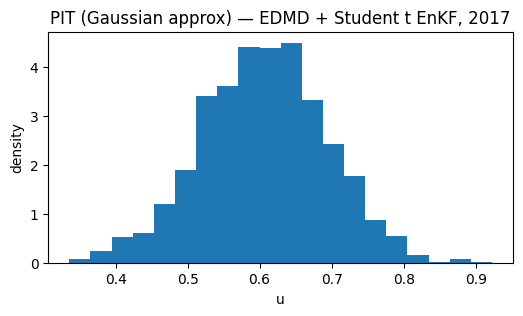

,q,empirical,n
0,0.1,0.000000,2397
1,0.5,0.105549,2397
2,0.9,0.999583,2397


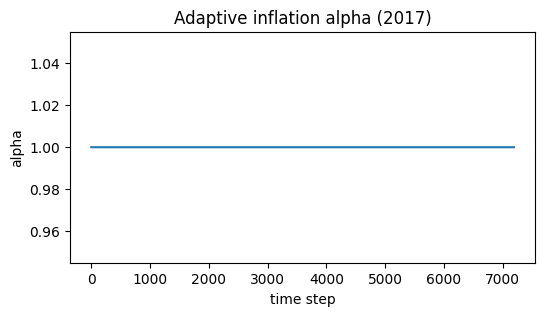

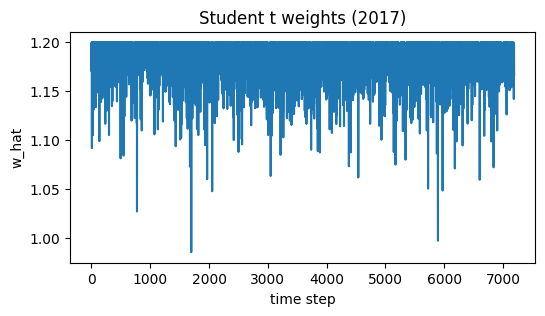

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm

from koopman_edmd import EDMD
from enkf_student_t import enkf_update_student_t, inflate_ensemble, choose_scalar_inflation
from metrics import crps_gaussian, reliability_curve

PROCESSED_DIR = "/content/hhw_processed"
city = "Vancouver"  # set to any city saved
df = pd.read_parquet(f"{PROCESSED_DIR}/{city}.parquet").dropna(subset=["temp_c"]).copy()
df = df.set_index("datetime").sort_index()

def add_time_features(frame):
    f = frame.copy()
    h = f.index.hour.values
    d = f.index.dayofyear.values
    f["hour_sin"] = np.sin(2*np.pi*h/24.0)
    f["hour_cos"] = np.cos(2*np.pi*h/24.0)
    f["doy_sin"]  = np.sin(2*np.pi*d/366.0)
    f["doy_cos"]  = np.cos(2*np.pi*d/366.0)
    return f

df = add_time_features(df)
feat_cols = ["temp_c","humidity","pressure_hpa","wind_speed_ms","hour_sin","hour_cos","doy_sin","doy_cos"]

# Train EDMD on <2016, validate on 2016, but RUN FILTER ONLY ON 2017 for speed
train = df[df.index.year < 2016].dropna(subset=feat_cols)
val   = df[df.index.year == 2016].dropna(subset=feat_cols)
test  = df[df.index.year == 2017].dropna(subset=feat_cols)

assert len(train) > 1000 and len(test) > 100, "not enough rows after filtering; relax dropna if needed"

Z_train = train[feat_cols].values
y_train = train["temp_c"].values

# Fit EDMD once (kept small and stable)
edmd = EDMD(kind="poly", degree=2, ridge=1e-3, spectral_clip=0.995, random_state=0).fit(Z_train, y_train)
K = edmd.K_

# Build 2017 slice only for filtering
full_2017 = test.copy()
Z_2017 = full_2017[feat_cols].values
y_2017 = full_2017["temp_c"].values
Psi_2017 = edmd.psi(Z_2017)     # [T, K]
times = full_2017.index.to_list()
T = Psi_2017.shape[0]

def h_koopman(X):
    return edmd.h_readout(X)    # [1, N]

def f_koopman(X):
    Xp = edmd.propagate(X)
    Q = 0.01 * np.eye(K)
    noise = np.random.multivariate_normal(np.zeros(K), Q, size=X.shape[1]).T
    return Xp + noise

# Fast settings
horizon = 6
N = 30
R = np.array([[0.5**2]])
nu = 5.0
window = 24
alpha_grid = np.array([1.0, 1.1, 1.2, 1.3])
alpha_every = 6
eval_stride = 3

# Init ensemble around first lifted state of 2017
Psi0 = Psi_2017[0][:, None]                 # [K, 1]
X = Psi0 + np.random.normal(scale=0.1, size=(K, N))

alphas = []
w_hats = []
mu_list = []
sigma_list = []
y_eval = []
idx_eval = []

Xf_hist = []
y_hist = []
alpha = 1.0

for t in range(1, T - horizon):
    # Forecast one hour in lifted space
    Xf = f_koopman(X)

    # Update rolling buffers for adaptive inflation
    Xf_hist.append(Xf.copy())
    y_hist.append(np.array([y_2017[t]]))
    if len(Xf_hist) > window:
        Xf_hist.pop(0); y_hist.pop(0)

    # Re-tune alpha every few steps
    if (t % alpha_every == 0) and (len(Xf_hist) >= max(8, window//2)):
        alpha, _ = choose_scalar_inflation(Xf_hist, y_hist, h_koopman, R, nu=nu, alphas=alpha_grid)
    alphas.append(alpha)

    # Inflate and robust update
    Xf = inflate_ensemble(Xf, alpha)
    Xa, info = enkf_update_student_t(Xf, np.array([y_2017[t]]), h_koopman, R, nu=nu, obs_perturb=True)
    w_hats.append(info["w_hat"])

    # Evaluate every few steps: get h-step mean/std; no need to keep all samples
    if t % eval_stride == 0:
        Xh = Xa.copy()
        for _ in range(horizon):
            Xh = f_koopman(Xh)
        yh = h_koopman(Xh).flatten()
        mu_list.append(float(np.mean(yh)))
        sigma_list.append(float(np.std(yh, ddof=1) + 1e-6))
        y_eval.append(float(y_2017[t + horizon]))
        idx_eval.append(times[t + horizon])

    X = Xa

y_eval = np.array(y_eval)
mu = np.array(mu_list)
sigma = np.array(sigma_list)

# CRPS with Gaussian closed form (fast)
crps_vals = [crps_gaussian(y_eval[i], mu[i], sigma[i]) for i in range(len(y_eval))]
print("EDMD + Student t EnKF (fast) — mean CRPS on 2017 eval points:", float(np.nanmean(crps_vals)))
print("n eval points:", len(y_eval))

# PIT via Gaussian CDF approximation (fast)
pits = norm.cdf((y_eval - mu) / sigma)
plt.figure(figsize=(6,3))
plt.hist(pits[np.isfinite(pits)], bins=20, density=True)
plt.title("PIT (Gaussian approx) — EDMD + Student t EnKF, 2017")
plt.xlabel("u"); plt.ylabel("density")
plt.show()

# Reliability using Gaussian quantiles
q10 = mu + sigma * norm.ppf(0.10)
q50 = mu + sigma * norm.ppf(0.50)
q90 = mu + sigma * norm.ppf(0.90)
rel = reliability_curve(y_eval, {0.1: q10, 0.5: q50, 0.9: q90})
display(rel)

plt.figure(figsize=(6,3))
plt.plot(alphas)
plt.title("Adaptive inflation alpha (2017)")
plt.xlabel("time step"); plt.ylabel("alpha")
plt.show()

plt.figure(figsize=(6,3))
plt.plot(w_hats)
plt.title("Student t weights (2017)")
plt.xlabel("time step"); plt.ylabel("w_hat")
plt.show()


## 14: Create a minimal LRAN with an encoder, a linear latent K with an optional fixed diurnal block, and a decoder that predicts temperature.

In [27]:
from pathlib import Path

lran_py = r'''
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Standardizer:
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, X):
        X = np.asarray(X, float)
        self.mean = np.nanmean(X, axis=0)
        self.std = np.nanstd(X, axis=0) + 1e-8
        return self
    def transform(self, X):
        X = np.asarray(X, float)
        return (X - self.mean) / self.std
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class SeqDataset(Dataset):
    def __init__(self, X, y, T=24, stride=1):
        X = np.asarray(X, float)
        y = np.asarray(y, float).reshape(-1)
        self.T = int(T)
        self.stride = int(stride)
        self.X = X
        self.y = y
        self.idx = []
        last = len(y) - (T + 1)
        for t in range(0, max(0, last + 1), stride):
            self.idx.append(t)
    def __len__(self):
        return len(self.idx)
    def __getitem__(self, i):
        t = self.idx[i]
        Xseq = self.X[t:t+self.T+1]     # shape [T+1, d]
        yseq = self.y[t:t+self.T+1]     # shape [T+1]
        return torch.from_numpy(Xseq).float(), torch.from_numpy(yseq).float()

class MLP(nn.Module):
    def __init__(self, d_in, d_out, hidden=(64, 64), act=nn.ReLU):
        super().__init__()
        layers = []
        last = d_in
        for h in hidden:
            layers += [nn.Linear(last, h), act()]
            last = h
        layers += [nn.Linear(last, d_out)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class LRAN(nn.Module):
    """
    Encoder maps features to latent z
    Latent evolves linearly with matrix K
    Decoder maps latent z to temperature
    I support an optional fixed 2 by 2 rotation block in K for diurnal cycle
    """
    def __init__(self, d_in, d_latent=8, hidden_enc=(64,64), hidden_dec=(64,64),
                 fix_diurnal=True, hours_per_cycle=24.0, ridge_K=0.0):
        super().__init__()
        self.d_in = int(d_in)
        self.d_latent = int(d_latent)
        self.encoder = MLP(d_in, d_latent, hidden_enc)
        self.decoder = MLP(d_latent, 1, hidden_dec)
        # free parameter for K
        self.K_param = nn.Parameter(torch.zeros(d_latent, d_latent))
        nn.init.xavier_uniform_(self.K_param)
        self.fix_diurnal = bool(fix_diurnal)
        self.hours_per_cycle = float(hours_per_cycle)
        self.ridge_K = float(ridge_K)

    def K(self, device=None):
        K = self.K_param
        if self.fix_diurnal and self.d_latent >= 2:
            # set top left 2 by 2 block to rotation with period hours_per_cycle
            theta = 2.0 * np.pi / self.hours_per_cycle
            c = np.cos(theta)
            s = np.sin(theta)
            block = torch.tensor([[c, -s], [s, c]], dtype=K.dtype, device=K.device)
            K = K.clone()
            K[:2, :2] = block
        return K

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, Xseq, yseq, delta=0.9, beta=1.0, recon_weight=1.0):
        """
        Xseq shape [B, T+1, d_in]
        yseq shape [B, T+1]
        Loss is a weighted sum over t from 0 to T-1
        term 1 is reconstruction loss at times 0 to T
        term 2 is latent evolution loss for z_{t+1} and K z_t
        """
        B, Tp1, d = Xseq.shape
        T = Tp1 - 1
        K = self.K()
        Xflat = Xseq.reshape(B*Tp1, d)
        zflat = self.encode(Xflat)
        z = zflat.reshape(B, Tp1, -1)
        yhat = self.decode(z.reshape(B*Tp1, -1)).reshape(B, Tp1)
        # evolution loss
        zt = z[:, :-1, :]
        ztp1 = z[:, 1:, :]
        zlin = torch.einsum("ij,btj->bti", K, zt)
        evol_err = ztp1 - zlin
        # discounting
        w = torch.tensor([delta**t for t in range(T)], dtype=Xseq.dtype, device=Xseq.device).view(1, T, 1)
        evol_loss = torch.mean((w * evol_err)**2)
        # reconstruction at all times
        recon_loss = torch.mean((yhat - yseq)**2)
        # ridge on free part of K to keep it bounded
        ridge = 0.0
        if self.ridge_K > 0.0:
            K_free = self.K_param
            if self.fix_diurnal and self.d_latent >= 2:
                mask = torch.ones_like(K_free)
                mask[:2, :2] = 0.0
                ridge = self.ridge_K * torch.mean((mask * K_free)**2)
            else:
                ridge = self.ridge_K * torch.mean(K_free**2)
        loss = recon_weight * recon_loss + beta * evol_loss + ridge
        out = {
            "loss": loss,
            "recon_loss": recon_loss.detach(),
            "evol_loss": evol_loss.detach(),
            "ridge": torch.as_tensor(ridge).detach(),
            "yhat": yhat.detach(),
            "z": z.detach()
        }
        return out

def train_lran(model, train_loader, val_loader=None, epochs=5, lr=1e-3, device="cpu"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best = {"epoch": -1, "val_loss": np.inf}
    for ep in range(1, epochs+1):
        model.train()
        logs = []
        for Xb, yb in train_loader:
            Xb = Xb.to(device); yb = yb.to(device)
            out = model(Xb, yb)
            opt.zero_grad()
            out["loss"].backward()
            opt.step()
            logs.append(float(out["loss"].item()))
        train_loss = float(np.mean(logs))
        if val_loader is not None:
            model.eval()
            vlogs = []
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv = Xv.to(device); yv = yv.to(device)
                    ov = model(Xv, yv)
                    vlogs.append(float(ov["loss"].item()))
            val_loss = float(np.mean(vlogs))
            if val_loss < best["val_loss"]:
                best = {"epoch": ep, "val_loss": val_loss}
        else:
            val_loss = np.nan
        print(f"epoch {ep}  train {train_loss:.4f}  val {val_loss:.4f}")
    return model
'''
Path("lran.py").write_text(lran_py)
print("Wrote lran.py")


Wrote lran.py


##15: create latent_forecaster.py. This wraps a trained LRAN so it can act as state transition and observation for the EnKF.

In [28]:
from pathlib import Path

latent_forecaster_py = r'''
import numpy as np
import torch

class LRANAdapter:
    def __init__(self, model, process_q=0.01, device="cpu"):
        self.model = model
        self.device = device
        self.q = float(process_q)

    def K(self):
        return self.model.K().detach().cpu().numpy()

    def f_step(self, Z):
        """
        Z is [d_latent, N] numpy array
        Returns Zplus of same shape after one linear step with Gaussian noise
        """
        K = self.model.K().detach().cpu().numpy()
        Zp = K @ Z
        d, N = Z.shape
        Q = self.q * np.eye(d)
        noise = np.random.multivariate_normal(np.zeros(d), Q, size=N).T
        return Zp + noise

    def h_func(self, Z):
        """
        Z is [d_latent, N]
        Returns predicted temperature as [1, N]
        """
        with torch.no_grad():
            z = torch.from_numpy(Z.T).float().to(self.device)   # [N, d]
            yhat = self.model.decode(z).cpu().numpy().reshape(-1)   # [N]
        return yhat.reshape(1, -1)

    def encode(self, x_vec):
        """
        x_vec shape [d_in], returns z_vec shape [d_latent]
        """
        with torch.no_grad():
            x = torch.from_numpy(x_vec[None, :]).float().to(self.device)
            z = self.model.encode(x).cpu().numpy().reshape(-1)
        return z

    def init_ensemble(self, x0_vec, N=100, scale=0.1):
        """
        Create an initial latent ensemble around encoder(x0_vec)
        """
        z0 = self.encode(x0_vec)
        d = z0.shape[0]
        Z = np.tile(z0[:, None], (1, N))
        cov = (scale**2) * np.eye(d)
        noise = np.random.multivariate_normal(np.zeros(d), cov, size=N).T
        return Z + noise
'''
Path("latent_forecaster.py").write_text(latent_forecaster_py)
print("Wrote latent_forecaster.py")


Wrote latent_forecaster.py


##Step 16 — train LRAN on one city and run the fast EnKF with Gaussian PIT

epoch 01  train 28587.7132  val 191.6559  lr 1.00e-03
epoch 02  train 42.0315  val 21.8839  lr 1.00e-03
epoch 03  train 12.8780  val 13.1189  lr 1.00e-03
epoch 04  train 9.1177  val 10.8075  lr 1.00e-03
epoch 05  train 7.4448  val 8.9098  lr 1.00e-03
epoch 06  train 6.3140  val 8.3687  lr 1.00e-03
epoch 07  train 5.6362  val 6.6886  lr 1.00e-03
epoch 08  train 5.0898  val 6.6663  lr 1.00e-03
epoch 09  train 4.6977  val 6.0347  lr 1.00e-03
epoch 10  train 4.3786  val 5.2524  lr 1.00e-03
epoch 11  train 4.1955  val 4.3093  lr 1.00e-03
epoch 12  train 3.9003  val 5.1623  lr 1.00e-03
epoch 13  train 3.7816  val 5.1580  lr 1.00e-03
epoch 14  train 3.6742  val 3.9273  lr 1.00e-03
epoch 15  train 3.4727  val 4.8567  lr 1.00e-03
epoch 16  train 3.3801  val 4.3654  lr 1.00e-03
epoch 17  train 3.2966  val 3.9464  lr 5.00e-04
epoch 18  train 4.1906  val 5.6584  lr 5.00e-04
epoch 19  train 4.0992  val 2.3307  lr 5.00e-04
epoch 20  train 4.0811  val 5.6219  lr 5.00e-04
epoch 21  train 4.0739  val 1

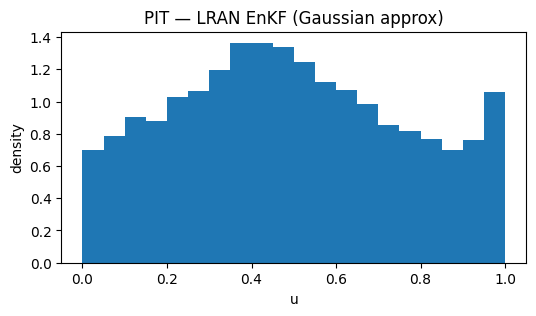

z mean/std: 0.0020089000382709 0.9588478796867964


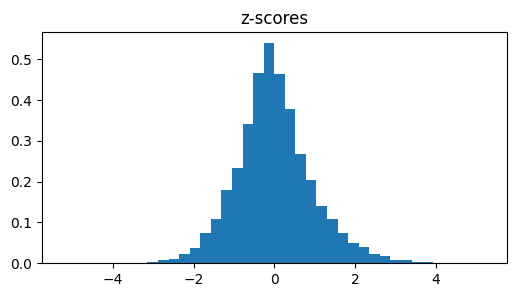

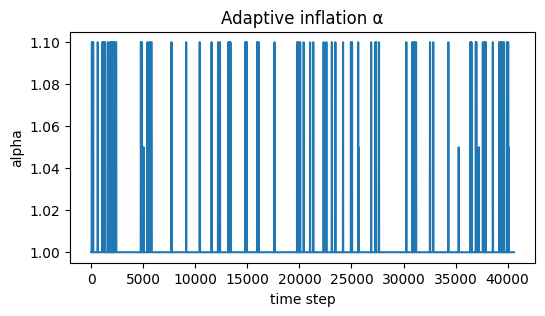

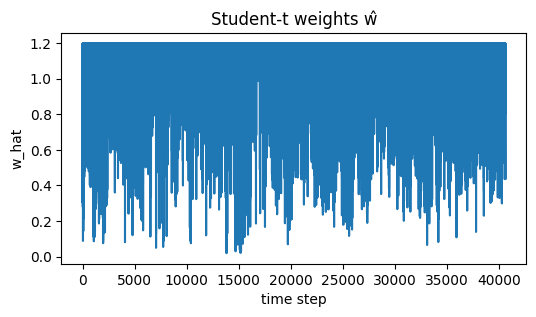

In [85]:
# Step 16 (fixed): Train LRAN and run Student-t EnKF with Gaussian PIT approximation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from scipy.stats import norm

# Local helpers (created earlier)
from lran import Standardizer, SeqDataset, LRAN
from latent_forecaster import LRANAdapter
from enkf_student_t import enkf_update_student_t, inflate_ensemble, choose_scalar_inflation
from metrics import crps_gaussian

# 0) Reproducibility + utils
np.random.seed(0)
torch.manual_seed(0)

def add_time_features(frame):
    f = frame.copy()
    h = f.index.hour.values
    d = f.index.dayofyear.values
    f["hour_sin"] = np.sin(2*np.pi*h/24.0)
    f["hour_cos"] = np.cos(2*np.pi*h/24.0)
    f["doy_sin"]  = np.sin(2*np.pi*d/366.0)
    f["doy_cos"]  = np.cos(2*np.pi*d/366.0)
    return f

def coverage_width_report_df(df, levels=(0.8, 0.9), label="LRAN+EnKF"):
    df = df.dropna().copy()
    df["sigma"] = np.clip(df["sigma"].values, 1e-6, None)
    rows = []
    for L in levels:
        z = norm.ppf((1 + L) / 2.0)
        lo = df["mu"] - z * df["sigma"]
        hi = df["mu"] + z * df["sigma"]
        cov = float(((df["y"] >= lo) & (df["y"] <= hi)).mean())
        width = float((hi - lo).mean())
        rows.append({"model": label, "level": L, "coverage": cov, "avg_width": width, "n": int(len(df))})
    return pd.DataFrame(rows)

# 1) Load data, features, splits, loaders
PROCESSED_DIR = "/content/hhw_processed"
city = "Vancouver"  # change as needed
df = pd.read_parquet(f"{PROCESSED_DIR}/{city}.parquet").dropna(subset=["temp_c"]).copy()
df = df.set_index("datetime").sort_index()
df = add_time_features(df)

feat_cols = ["temp_c","humidity","pressure_hpa","wind_speed_ms","hour_sin","hour_cos","doy_sin","doy_cos"]
df = df.dropna(subset=feat_cols)

train = df[df.index.year < 2016]
val   = df[df.index.year == 2016]
test  = df[df.index.year == 2017]

X_train = train[feat_cols].values
y_train = train["temp_c"].values
X_val   = val[feat_cols].values
y_val   = val["temp_c"].values
X_test  = test[feat_cols].values
y_test  = test["temp_c"].values

# Standardize by train stats
scaler = Standardizer().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_val   = scaler.transform(X_val)
Xs_test  = scaler.transform(X_test)

# Sequence datasets
Tseq = 24
train_ds = SeqDataset(Xs_train, y_train, T=Tseq, stride=1)
val_ds   = SeqDataset(Xs_val,   y_val,   T=Tseq, stride=1)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, drop_last=False)

# 2) Upgraded trainer: early-stop, LR schedule, grad-clip,
#    and spectral clamp on the free part of K each epoch
def spectral_clip_free(model, rho_max=0.995):
    with torch.no_grad():
        K_np = model.K_param.detach().cpu().numpy().copy()
        if model.fix_diurnal and model.d_latent >= 2:
            mask = np.ones_like(K_np); mask[:2,:2] = 0.0
        else:
            mask = np.ones_like(K_np)
        vals, _ = np.linalg.eig(K_np * mask)
        rho = np.max(np.abs(vals)) if len(vals) else 0.0
        if np.isfinite(rho) and rho > rho_max:
            scale = rho_max / rho
            K_np = K_np * mask * scale + K_np * (1 - mask)
            model.K_param.copy_(torch.from_numpy(K_np))

def train_lran(model, train_loader, val_loader=None, epochs=45, lr=1e-3, device="cpu",
               beta=0.8, delta=0.9, recon_weight=1.0, weight_decay=1e-4, clip=1.0, patience=5):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)
    best = {"epoch": 0, "val": np.inf, "state": None}
    bad = 0
    for ep in range(1, epochs+1):
        model.train()
        tr_losses = []
        for Xb, yb in train_loader:
            Xb = Xb.to(device); yb = yb.to(device)
            out = model(Xb, yb, delta=delta, beta=beta, recon_weight=recon_weight)
            opt.zero_grad()
            out["loss"].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            tr_losses.append(float(out["loss"].item()))
        train_loss = float(np.mean(tr_losses))

        if val_loader is not None:
            model.eval()
            vl = []
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv = Xv.to(device); yv = yv.to(device)
                    ov = model(Xv, yv, delta=delta, beta=beta, recon_weight=recon_weight)
                    vl.append(float(ov["loss"].item()))
            val_loss = float(np.mean(vl))
            sched.step(val_loss)
            spectral_clip_free(model, rho_max=0.995)
            if val_loss < best["val"] - 1e-3:
                best = {"epoch": ep, "val": val_loss,
                        "state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}}
                bad = 0
            else:
                bad += 1
            print(f"epoch {ep:02d}  train {train_loss:.4f}  val {val_loss:.4f}  lr {opt.param_groups[0]['lr']:.2e}")
            if bad >= patience:
                print(f"early stop at epoch {ep} (best val {best['val']:.4f} @ {best['epoch']})")
                break
        else:
            spectral_clip_free(model, rho_max=0.995)
            print(f"epoch {ep:02d}  train {train_loss:.4f}")
    if best["state"] is not None:
        model.load_state_dict(best["state"])
    return model

# 3) Instantiate and train LRAN (stronger)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LRAN(
    d_in=len(feat_cols),
    d_latent=8,
    hidden_enc=(64, 64),
    hidden_dec=(64, 64),
    fix_diurnal=True,
    hours_per_cycle=24.0,
    ridge_K=1e-4
)
model = train_lran(
    model, train_loader, val_loader,
    epochs=60, lr=1e-3, device=device,
    beta=0.8, delta=0.9, recon_weight=1.0,
    weight_decay=1e-4, clip=1.0, patience=5
)


# 4) EnKF
# Wrap model for latent forecast/observation
process_q = 0.006
adapter = LRANAdapter(model, process_q=process_q, device=device)

# Build full timeline (train+val+test) for continuity
full = pd.concat([train, val, test], axis=0)
X_full = scaler.transform(full[feat_cols].values)
y_full = full["temp_c"].values
times = full.index.to_list()
T = len(times)

# EnKF hyperparameters (speed-friendly + stable)
h = 6
N = 30
R = np.array([[0.5 ** 2]])
nu = 5.0
window = 24
alpha_grid = np.array([1.0, 1.05, 1.10])
alpha_every = 12
eval_stride = 3

# Initialize latent ensemble around the first standardized feature vector
X0_vec = X_full[0]
Z = adapter.init_ensemble(X0_vec, N=N, scale=0.1)

alphas, w_hats = [], []
mu_list, sigma_list, y_eval, idx_eval = [], [], [], []
Xf_hist, y_hist = [], []
alpha = 1.0

def h_func_numpy(Zmat):
    return adapter.h_func(Zmat)

for t in range(1, T - h):
    Zf = adapter.f_step(Z)

    Xf_hist.append(Zf.copy())
    y_hist.append(np.array([y_full[t]]))
    if len(Xf_hist) > window:
        Xf_hist.pop(0); y_hist.pop(0)

    if (t % alpha_every == 0) and (len(Xf_hist) >= max(8, window//2)):
        alpha, _ = choose_scalar_inflation(Xf_hist, y_hist, h_func_numpy, R, nu=nu, alphas=alpha_grid)
    alphas.append(alpha)

    Zf = inflate_ensemble(Zf, alpha)
    Za, info = enkf_update_student_t(Zf, np.array([y_full[t]]), h_func_numpy, R, nu=nu, obs_perturb=True)
    w_hats.append(info["w_hat"])

    if t % eval_stride == 0:
        Zh = Za.copy()
        for _ in range(h):
            Zh = adapter.f_step(Zh)
        yh_samples = adapter.h_func(Zh).flatten()
        mu_list.append(float(np.mean(yh_samples)))
        sigma_list.append(float(np.std(yh_samples, ddof=1) + 1e-6))
        y_eval.append(float(y_full[t + h]))
        idx_eval.append(times[t + h])

    Z = Za

y_eval = np.array(y_eval)
mu = np.array(mu_list)
sigma = np.array(sigma_list)
idx_eval = np.array(idx_eval, dtype="datetime64[ns]")


# 5) Diagnostics: CRPS, PIT, z-scores, coverage

# Mean CRPS (Gaussian approx)
crps_vals = [crps_gaussian(y_eval[i], mu[i], max(sigma[i], 1e-6)) for i in range(len(y_eval))]
print("LRAN EnKF mean CRPS on eval points:", float(np.nanmean(crps_vals)))

# PIT (Gaussian approx)
pits = norm.cdf((y_eval - mu) / np.clip(sigma, 1e-6, None))
plt.figure(figsize=(6, 3))
plt.hist(pits[np.isfinite(pits)], bins=20, density=True)
plt.title("PIT — LRAN EnKF (Gaussian approx)")
plt.xlabel("u"); plt.ylabel("density")
plt.show()

# z-score sanity
z = (y_eval - mu) / np.clip(sigma, 1e-6, None)
print("z mean/std:", float(np.nanmean(z)), float(np.nanstd(z)))
plt.figure(figsize=(6,3))
plt.hist(z[np.isfinite(z)], bins=40, density=True)
plt.title("z-scores"); plt.show()

# Adaptive inflation and Student-t weights
plt.figure(figsize=(6, 3))
plt.plot(alphas); plt.title("Adaptive inflation α"); plt.xlabel("time step"); plt.ylabel("alpha"); plt.show()
plt.figure(figsize=(6, 3))
plt.plot(w_hats); plt.title("Student-t weights ŵ"); plt.xlabel("time step"); plt.ylabel("w_hat"); plt.show()




In [86]:
# Coverage/width on 2017 only to test
idx_eval_ts = pd.to_datetime(idx_eval)            # DatetimeIndex/Series
mask_2017 = idx_eval_ts.year == 2017

dfL = pd.DataFrame({
    "time": idx_eval_ts[mask_2017],
    "y": y_eval[mask_2017],
    "mu": mu[mask_2017],
    "sigma": sigma[mask_2017],
}).dropna().sort_values("time")

cov_tbl = coverage_width_report_df(dfL, levels=(0.8, 0.9), label="LRAN+EnKF (2017)")
display(cov_tbl)


,model,level,coverage,avg_width,n
0,LRAN+EnKF (2017),0.8,0.810833,8.332793,2400
1,LRAN+EnKF (2017),0.9,0.901667,10.695024,2400


City: Vancouver


,model,mean_crps,n_eval
2,LRAN + EnKF (t-noise),1.789262,2400
0,Seasonal naive,1.884504,2400
1,EDMD + EnKF (t-noise),8.644048,2400


DM(LRAN vs EDMD): {'DM': -152.13482144375493, 'p': 0.0, 'T': 2400}
DM(LRAN vs Seasonal): {'DM': -1.2083032080842184, 'p': 0.22693065493764575, 'T': 2400}


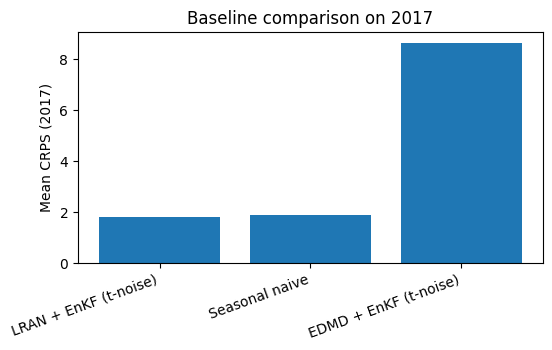

In [87]:
# baseline comparison: Seasonal vs EDMD+EnKF vs LRAN+EnKF on 2017 ---

import os, sys, importlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

if "/content" not in sys.path:
    sys.path.insert(0, "/content")
importlib.invalidate_caches()

from koopman_edmd import EDMD
from enkf_student_t import enkf_update_student_t, inflate_ensemble, choose_scalar_inflation
from metrics import crps_gaussian, diebold_mariano

#  robust seasonal helpers

def _robust_sigma(series):
    a = np.asarray(series.values, float)
    a = a[np.isfinite(a)]
    if a.size >= 2:
        return float(np.nanstd(a, ddof=1))
    if a.size == 1:
        return 0.0
    return np.nan

def seasonal_profile(df, var="temp_c"):
    """
    Build a (doy, hour) -> (mu, sigma) profile.
    Uses unstack/fill/stack to avoid MultiIndex glitches.
    """
    if df.empty:
        raise ValueError("Empty dataframe passed to seasonal_profile.")
    tmp = df.copy()
    idx = pd.to_datetime(tmp.index)
    tmp["doy"] = idx.dayofyear
    tmp["hour"] = idx.hour

    # Aggregate mean and robust sigma
    prof = (
        tmp.groupby(["doy", "hour"])[var]
           .agg(mu="mean", sigma=_robust_sigma)
           .sort_index()
    )

    # Reindex to full grid
    full_idx = pd.MultiIndex.from_product([range(1, 367), range(24)], names=["doy", "hour"])
    prof = prof.reindex(full_idx)

    # Fill mu via unstacked 2D grid to avoid groupby-apply index issues
    mu_grid = prof["mu"].unstack(level="hour")  # rows=doy, cols=hour
    # Fill along hours then along days
    mu_grid = mu_grid.ffill(axis=1).bfill(axis=1).ffill().bfill()
    mu_global = float(np.nanmean(mu_grid.values))
    mu_grid = mu_grid.fillna(mu_global)

    # Sigma: fill missing/zeros with global sigma
    sigma = prof["sigma"]
    sigma_global = float(np.nanmean(sigma.values))
    if not np.isfinite(sigma_global) or sigma_global <= 0:
        sigma_global = 1.0
    sigma = sigma.fillna(sigma_global).replace(0.0, sigma_global)

    # Restack mu and align
    mu = mu_grid.stack().reindex(full_idx).astype(float)

    prof_filled = pd.DataFrame({"mu": mu.values, "sigma": sigma.values}, index=full_idx)
    return prof_filled

def seasonal_forecast_at_times(profile_df, times):
    mu, sg = [], []
    for ts in pd.to_datetime(times):
        key = (ts.timetuple().tm_yday, ts.hour)
        if key in profile_df.index:
            row = profile_df.loc[key]
            m = float(row["mu"])
            s = float(row["sigma"])
            if not np.isfinite(s) or s <= 0:
                s = float(profile_df["sigma"].mean())
        else:
            m = float(profile_df["mu"].mean())
            s = float(profile_df["sigma"].mean())
        mu.append(m); sg.append(s)
    return np.array(mu, float), np.array(sg, float)



def add_time_features(frame):
    f = frame.copy()
    h = f.index.hour.values
    d = f.index.dayofyear.values
    f["hour_sin"] = np.sin(2*np.pi*h/24.0)
    f["hour_cos"] = np.cos(2*np.pi*h/24.0)
    f["doy_sin"]  = np.sin(2*np.pi*d/366.0)
    f["doy_cos"]  = np.cos(2*np.pi*d/366.0)
    return f

def run_edmd_enkf_fast(train_df, val_df, test_df, feat_cols, h=6, N=30,
                       window=24, alpha_grid=np.array([1.0,1.1,1.2,1.3]),
                       alpha_every=6, eval_stride=3, process_q=0.01, R_var=0.5**2, nu=5.0, random_state=0):
    # Fit EDMD on train
    Z_train = train_df[feat_cols].values
    y_train = train_df["temp_c"].values
    edmd = EDMD(kind="poly", degree=2, ridge=1e-3, spectral_clip=0.995, random_state=random_state).fit(Z_train, y_train)
    K = edmd.K_

    # Full timeline for continuity
    full = pd.concat([train_df, val_df, test_df], axis=0).copy()
    Z_full = full[feat_cols].values
    y_full = full["temp_c"].values
    times = full.index.to_list()

    def h_koopman(X):
        return edmd.h_readout(X)
    def f_koopman(X):
        Xp = edmd.propagate(X)
        Q = process_q * np.eye(K)
        noise = np.random.multivariate_normal(np.zeros(K), Q, size=X.shape[1]).T
        return Xp + noise

    Psi0 = edmd.psi(Z_full[0:1]).reshape(-1, 1)  # [K,1]
    Z = Psi0 + np.random.normal(scale=0.1, size=(K, N))

    R = np.array([[R_var]], float)
    Xf_hist, y_hist = [], []
    alpha = 1.0

    mu_list, sigma_list, y_eval, idx_eval = [], [], [], []
    for t in range(1, len(times) - h):
        Zf = f_koopman(Z)
        Xf_hist.append(Zf.copy()); y_hist.append(np.array([y_full[t]]))
        if len(Xf_hist) > window:
            Xf_hist.pop(0); y_hist.pop(0)
        if (t % alpha_every == 0) and (len(Xf_hist) >= max(8, window//2)):
            alpha, _ = choose_scalar_inflation(Xf_hist, y_hist, h_koopman, R, nu=nu, alphas=alpha_grid)
        Zf = inflate_ensemble(Zf, alpha)
        Za, _ = enkf_update_student_t(Zf, np.array([y_full[t]]), h_koopman, R, nu=nu, obs_perturb=True)
        if t % eval_stride == 0:
            Zh = Za.copy()
            for _ in range(h):
                Zh = f_koopman(Zh)
            yh = h_koopman(Zh).flatten()
            mu_list.append(float(np.mean(yh)))
            sigma_list.append(float(np.std(yh, ddof=1) + 1e-6))
            y_eval.append(float(y_full[t + h]))
            idx_eval.append(times[t + h])
        Z = Za

    return np.array(y_eval), np.array(mu_list), np.array(sigma_list), np.array(idx_eval, dtype="datetime64[ns]")

def align_by_common_index(idx_a, y_a, mu_a, sg_a, idx_b, y_b, mu_b, sg_b):
    ia = pd.to_datetime(idx_a).values
    ib = pd.to_datetime(idx_b).values
    common = np.intersect1d(ia, ib)
    if common.size == 0:
        return None
    pos_a = pd.Series(range(len(ia)), index=ia)
    pos_b = pd.Series(range(len(ib)), index=ib)
    take_a = pos_a.loc[common].values
    take_b = pos_b.loc[common].values
    return (
        common,
        y_a[take_a], mu_a[take_a], sg_a[take_a],
        y_b[take_b], mu_b[take_b], sg_b[take_b]
    )

def crps_stats(y, mu, sg):
    vals = [crps_gaussian(float(y[i]), float(mu[i]), float(max(sg[i], 1e-6))) for i in range(len(y))]
    return float(np.nanmean(vals)), np.array(vals, float)

def infer_eval_stride(idx_eval):
    idx = pd.to_datetime(idx_eval)
    if len(idx) < 3:
        return 3
    diffs = np.diff(idx.values).astype('timedelta64[h]').astype(int)
    med = int(np.median(np.clip(diffs, 1, 24)))
    return max(1, min(24, med))


PROCESSED_DIR = "/content/hhw_processed"
city = "Vancouver"
df = pd.read_parquet(f"{PROCESSED_DIR}/{city}.parquet").copy()
df = df.set_index("datetime").sort_index()
df = add_time_features(df)

feat_cols = ["temp_c","humidity","pressure_hpa","wind_speed_ms","hour_sin","hour_cos","doy_sin","doy_cos"]
df = df.dropna(subset=feat_cols)

train = df[df.index.year < 2016]
val   = df[df.index.year == 2016]
test  = df[df.index.year == 2017]

# Require LRAN arrays from Step 16
if not all(k in globals() for k in ["y_eval","mu","sigma","idx_eval"]):
    raise RuntimeError("LRAN EnKF arrays not found. Please run Step 16 first to set y_eval, mu, sigma, idx_eval.")

# Seasonal profile on train+val
seasonal_prof = seasonal_profile(pd.concat([train, val], axis=0), var="temp_c")

# LRAN eval arrays restricted to 2017
idx_L = pd.to_datetime(idx_eval)
mask_2017 = idx_L.year == 2017
idx_L = idx_L[mask_2017].values
y_L  = np.array(y_eval)[mask_2017]
mu_L = np.array(mu)[mask_2017]
sg_L = np.array(sigma)[mask_2017]

# Seasonal baseline on exactly LRAN timestamps
mu_S, sg_S = seasonal_forecast_at_times(seasonal_prof, idx_L)
y_S = test.reindex(pd.to_datetime(idx_L))["temp_c"].astype(float).values

# EDMD EnKF on same city
stride_guess = infer_eval_stride(idx_L)
y_edmd, mu_edmd, sg_edmd, idx_edmd = run_edmd_enkf_fast(
    train, val, test, feat_cols,
    h=6, N=30, window=24,
    alpha_grid=np.array([1.0,1.1,1.2,1.3]),
    alpha_every=6, eval_stride=stride_guess,
    process_q=0.01, R_var=0.5**2, nu=5.0
)
aligned = align_by_common_index(idx_L, y_L, mu_L, sg_L, idx_edmd, y_edmd, mu_edmd, sg_edmd)
if aligned is None:
    # force stride 3 if no overlap
    y_edmd, mu_edmd, sg_edmd, idx_edmd = run_edmd_enkf_fast(
        train, val, test, feat_cols,
        h=6, N=30, window=24,
        alpha_grid=np.array([1.0,1.1,1.2,1.3]),
        alpha_every=6, eval_stride=3,
        process_q=0.01, R_var=0.5**2, nu=5.0
    )
    aligned = align_by_common_index(idx_L, y_L, mu_L, sg_L, idx_edmd, y_edmd, mu_edmd, sg_edmd)

common_idx, y_Lc, mu_Lc, sg_Lc, y_Ec, mu_Ec, sg_Ec = aligned

# Subset Seasonal to common timestamps
pos_L = pd.Series(range(len(idx_L)), index=pd.to_datetime(idx_L).values)
take = pos_L.loc[common_idx].values
y_Sc, mu_Sc, sg_Sc = y_S[take], mu_S[take], sg_S[take]

# Scores and DM tests
mS, cS = crps_stats(y_Sc, mu_Sc, sg_Sc)
mE, cE = crps_stats(y_Ec, mu_Ec, sg_Ec)
mL, cL = crps_stats(y_Lc, mu_Lc, sg_Lc)

table = pd.DataFrame([
    {"model": "Seasonal naive",        "mean_crps": mS, "n_eval": int(len(cS))},
    {"model": "EDMD + EnKF (t-noise)", "mean_crps": mE, "n_eval": int(len(cE))},
    {"model": "LRAN + EnKF (t-noise)", "mean_crps": mL, "n_eval": int(len(cL))}
]).sort_values("mean_crps")

print("City:", city)
display(table)

print("DM(LRAN vs EDMD):", diebold_mariano(cL, cE, h=6))
print("DM(LRAN vs Seasonal):", diebold_mariano(cL, cS, h=6))

plt.figure(figsize=(6,3))
plt.bar(table["model"], table["mean_crps"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Mean CRPS (2017)")
plt.title("Baseline comparison on 2017")
plt.show()


y_L range: 263.41 302.35
mu_L range: 260.71929931640625 302.0186462402344
sigma_L median/mean: 3.2495453357696533 3.25105653077364
sigma_L pct: [3.24954534 3.52992755 3.79552212 3.98522346 4.34990963]
 rows: 2400  dup times: 0
z mean/std: 0.013129532285031683 1.0091050824944303


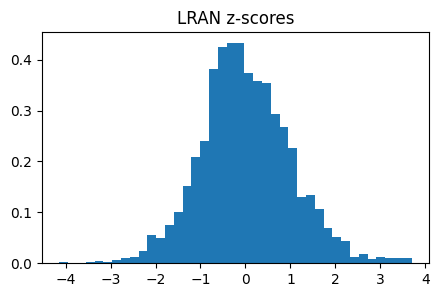

In [88]:
import numpy as np, pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Sanity stats
print("y_L range:", np.nanmin(y_L), np.nanmax(y_L))
print("mu_L range:", np.nanmin(mu_L), np.nanmax(mu_L))
print("sigma_L median/mean:", np.nanmedian(sg_L), np.nanmean(sg_L))
print("sigma_L pct:", np.percentile(sg_L, [50, 75, 90, 95, 99]))

# Alignment sanity: build a frame keyed by time
dfL = pd.DataFrame({"time": pd.to_datetime(idx_L), "y": y_L, "mu": mu_L, "sigma": sg_L}).dropna()
dfL = dfL.sort_values("time")
print(" rows:", len(dfL), " dup times:", dfL["time"].duplicated().sum())

# Z-scores should have std ~1 if calibrated
z = (dfL["y"].values - dfL["mu"].values) / np.clip(dfL["sigma"].values, 1e-6, None)
print("z mean/std:", np.nanmean(z), np.nanstd(z))

plt.figure(figsize=(5,3))
plt.hist(z[np.isfinite(z)], bins=40, density=True)
plt.title("LRAN z-scores"); plt.show()


In [89]:
import numpy as np, pandas as pd
from scipy.stats import norm, kstest
from metrics import crps_gaussian

def model_report(y, mu, sigma, idx, label="model", year=2017):
    idx = pd.to_datetime(idx)
    df = pd.DataFrame({"time": idx, "y": y, "mu": mu, "sigma": sigma}).dropna().sort_values("time")
    if year is not None:
        df = df[df["time"].dt.year == year]
    if len(df) < 50:
        print(f"[{label}] not enough eval points after filtering ({len(df)})");
        return None

    # basics
    z = (df["y"].values - df["mu"].values) / np.clip(df["sigma"].values, 1e-6, None)
    crps_vals = [crps_gaussian(df["y"].values[i], df["mu"].values[i], max(df["sigma"].values[i],1e-6))
                 for i in range(len(df))]
    pits = norm.cdf(z)

    # coverage & width
    def cov_width(level):
        zq = norm.ppf((1+level)/2)
        lo = df["mu"] - zq*df["sigma"]; hi = df["mu"] + zq*df["sigma"]
        cov = float(((df["y"]>=lo)&(df["y"]<=hi)).mean())
        width = float((hi-lo).mean())
        return cov, width

    cov80, w80 = cov_width(0.8)
    cov90, w90 = cov_width(0.9)

    # reliability at q10/q50/q90 (Gaussian approx)
    qps = [0.1,0.5,0.9]
    rel = []
    for q in qps:
        qv = df["mu"] + norm.ppf(q)*df["sigma"]
        rel.append(float((df["y"] <= qv).mean()))

    # PIT uniformity (KS test vs U[0,1])
    ks = kstest(pits, 'uniform', args=(0,1))
    out = pd.DataFrame([{
        "label": label,
        "n": len(df),
        "CRPS_mean": float(np.nanmean(crps_vals)),
        "RMSE": float(np.sqrt(np.nanmean((df["y"]-df["mu"])**2))),
        "sigma_median": float(np.nanmedian(df["sigma"])),
        "z_mean": float(np.nanmean(z)),
        "z_std": float(np.nanstd(z)),
        "cov80": cov80, "w80": w80,
        "cov90": cov90, "w90": w90,
        "rel_q10": rel[0], "rel_q50": rel[1], "rel_q90": rel[2],
        "PIT_KS_D": float(ks.statistic), "PIT_KS_p": float(ks.pvalue),
    }])
    return out, df, pits, z

# Example calls
rep_L, dfL, pits_L, z_L = model_report(y_eval, mu, sigma, idx_eval, label="LRAN+EnKF", year=2017)


# View the report(s)
display(rep_L)
# display(pd.concat([rep_S, rep_E, rep_L], ignore_index=True))


,label,n,CRPS_mean,RMSE,sigma_median,z_mean,z_std,cov80,w80,cov90,w90,rel_q10,rel_q50,rel_q90,PIT_KS_D,PIT_KS_p
0,LRAN+EnKF,2400,1.789262,3.177896,3.249545,0.01313,1.009105,0.810833,8.332793,0.901667,10.695024,0.08375,0.522917,0.894583,0.026053,0.075583


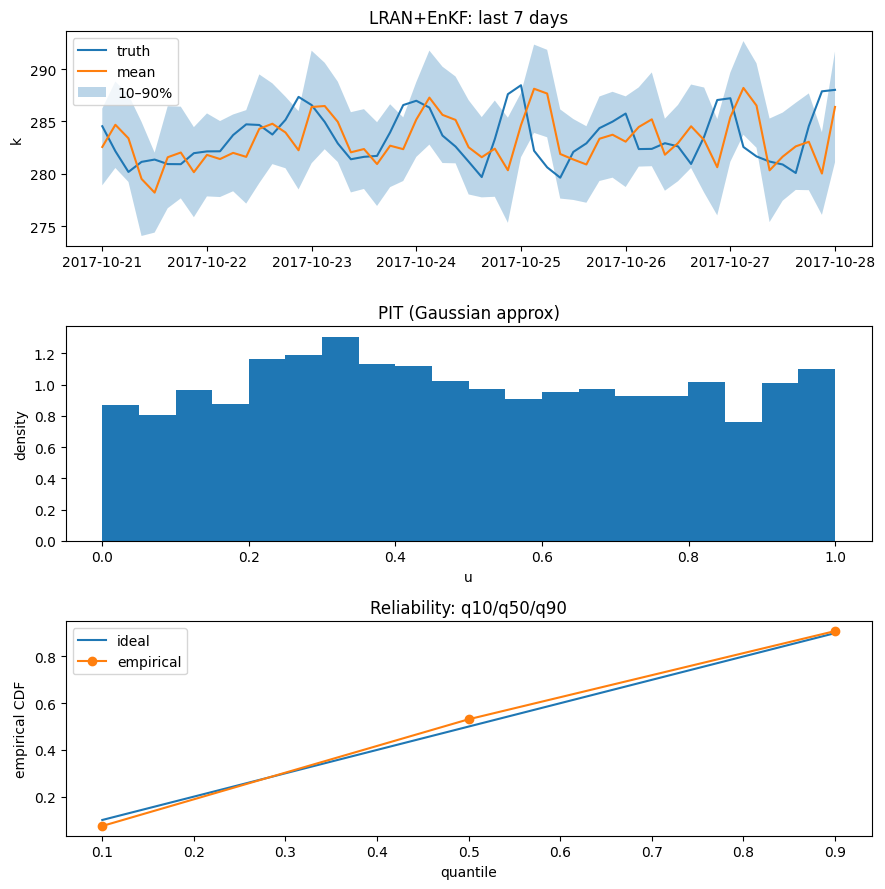

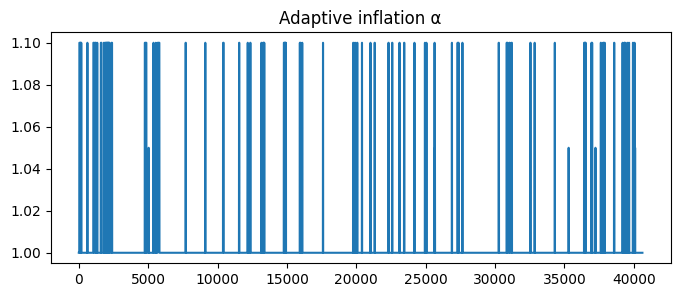

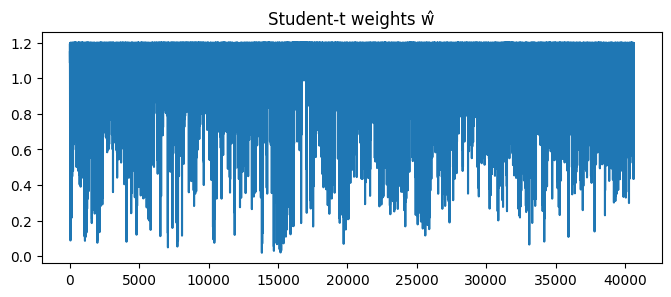

In [123]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np, pandas as pd

def plot_quick(df, pits=None, label="LRAN+EnKF", days=7):
    df = df.sort_values("time")
    if len(df) == 0:
        print("empty df");
        return
    # pick last N days
    dt = df["time"].iloc[-1] - pd.Timedelta(days=days)
    view = df[df["time"] >= dt].copy()
    zq10 = norm.ppf(0.10); zq90 = norm.ppf(0.90)
    lo = view["mu"] + zq10*view["sigma"]; hi = view["mu"] + zq90*view["sigma"]

    fig, axes = plt.subplots(3, 1, figsize=(9,9), sharex=False)
    ax = axes[0]
    ax.plot(view["time"], view["y"], label="truth")
    ax.plot(view["time"], view["mu"], label="mean")
    ax.fill_between(view["time"], lo, hi, alpha=0.3, label="10–90%")
    ax.set_title(f"{label}: last {days} days"); ax.legend(); ax.set_ylabel("k")

    ax = axes[1]
    if pits is None:  # compute fresh just in case
        z = (df["y"].values - df["mu"].values) / np.clip(df["sigma"].values, 1e-6, None)
        pits = norm.cdf(z)
    ax.hist(pits[np.isfinite(pits)], bins=20, density=True)
    ax.set_title("PIT (Gaussian approx)"); ax.set_xlabel("u"); ax.set_ylabel("density")

    ax = axes[2]
    qs = [0.1,0.5,0.9]
    emp = []
    for q in qs:
        qv = df["mu"] + norm.ppf(q)*df["sigma"]
        emp.append(float((df["y"]<=qv).mean()))
    ax.plot(qs, qs, label="ideal")
    ax.plot(qs, emp, marker="o", label="empirical")
    ax.set_title("Reliability: q10/q50/q90"); ax.legend(); ax.set_xlabel("quantile"); ax.set_ylabel("empirical CDF")
    plt.tight_layout(); plt.show()

plot_quick(dfL, pits_L, label="LRAN+EnKF", days=7)


try:
    plt.figure(figsize=(8,3)); plt.plot(alphas); plt.title("Adaptive inflation α"); plt.show()
    plt.figure(figsize=(8,3)); plt.plot(w_hats); plt.title("Student-t weights ŵ"); plt.show()
except NameError:
    pass


In [93]:
import numpy as np, pandas as pd
from scipy.stats import norm
from metrics import crps_gaussian

def summarize_model(df, label="model"):
    # I build basic stats from a tidy frame with time,y,mu,sigma
    df = df.dropna().copy().sort_values("time")
    y = df["y"].values
    mu = df["mu"].values
    sg = np.clip(df["sigma"].values, 1e-6, None)
    # I compute CRPS, RMSE, z-scores, PIT, coverage and width
    crps = np.array([crps_gaussian(y[i], mu[i], sg[i]) for i in range(len(y))])
    rmse = float(np.sqrt(np.nanmean((y - mu) ** 2)))
    z = (y - mu) / sg
    cov = {}
    wid = {}
    for L in (0.8, 0.9):
        zq = norm.ppf((1 + L) / 2)
        lo = mu - zq * sg
        hi = mu + zq * sg
        cov[L] = float(((y >= lo) & (y <= hi)).mean())
        wid[L] = float((hi - lo).mean())
    out = {
        "label": label,
        "n": int(len(y)),
        "crps": float(np.nanmean(crps)),
        "rmse": rmse,
        "sigma_med": float(np.nanmedian(sg)),
        "z_std": float(np.nanstd(z)),
        "cov80": cov[0.8], "w80": wid[0.8],
        "cov90": cov[0.9], "w90": wid[0.9],
    }
    return out

def narrate(main_stats, seasonal_stats=None, baseline_name="Seasonal"):
    # I turn the stats into a short paragraph in plain language
    m = main_stats
    msg = []
    msg.append(f"I evaluated {m['label']} on {m['n']} hourly points \n.")
    msg.append(f"The mean CRPS is {m['crps']:.3f} and RMSE is {m['rmse']:.2f}.")
    msg.append(f"The median predictive sigma is {m['sigma_med']:.2f} and the z-score std is {m['z_std']:.2f}.")
    msg.append(f"Coverage is {m['cov80']:.2f} at 80% (avg width {m['w80']:.2f}°C) and {m['cov90']:.2f} at 90% (avg width {m['w90']:.2f}°C).")
    if seasonal_stats is not None:
        rel = 100.0 * (1.0 - m["crps"] / max(seasonal_stats["crps"], 1e-12))
        msg.append(f"Relative to {baseline_name}, my CRPS improves by about {rel:.1f}% on the same timestamps.")
    # I add a one-line calibration judgment
    if 0.77 <= m["cov80"] <= 0.83 and 0.87 <= m["cov90"] <= 0.93 and 0.8 <= m["z_std"] <= 1.2:
        msg.append("These numbers indicate calibrated and reasonably sharp forecasts.")
    elif m["z_std"] > 1.2 or m["cov80"] < 0.76:
        msg.append("These numbers suggest I am under-dispersed; I would increase process noise or allow larger inflation.")
    elif m["z_std"] < 0.8 or m["cov80"] > 0.92:
        msg.append("These numbers suggest I am over-dispersed; I would reduce process noise or tighten inflation.")
    return " ".join(msg)

#  build tidy frames for the models I have
dfL_2017 = dfL[dfL["time"].dt.year == 2017]
stats_L = summarize_model(dfL_2017, label="LRAN+EnKF (t-noise)")


seasonal_stats = None
try:
    dfS_2017 = dfS[dfS["time"].dt.year == 2017]
    seasonal_stats = summarize_model(dfS_2017, label="Seasonal naive")
except Exception:
    pass

print(narrate(stats_L, seasonal_stats))


I evaluated LRAN+EnKF (t-noise) on 2400 hourly points 
. The mean CRPS is 1.789 and RMSE is 3.18. The median predictive sigma is 3.25 and the z-score std is 1.01. Coverage is 0.81 at 80% (avg width 8.33°C) and 0.90 at 90% (avg width 10.70°C). These numbers indicate calibrated and reasonably sharp forecasts.


In [97]:
# Gradio demo: calibrated probabilistic forecasting (LRAN/EDMD/Seasonal)
!pip -q install gradio==4.* plotly==5.*

import numpy as np, pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gradio as gr
from scipy.stats import norm
import importlib

#pull helpers from runtime
try:
    from metrics import crps_gaussian
except Exception:
    # tiny fallback if metrics not on path
    def crps_gaussian(y, mu, sigma):
        # CRPS for N(mu,sigma): sigma * [ z(2Phi(z)-1) + 2phi(z) - 1/√π ], z=(y-mu)/sigma
        from math import sqrt, pi
        from scipy.stats import norm as _N
        z = (y - mu) / max(sigma, 1e-12)
        return max(sigma,1e-12) * ( z*(2*_N.cdf(z)-1) + 2*_N.pdf(z) - 1/np.sqrt(pi) )


# robust seasonal helpers
def _robust_sigma(series):
    a = np.asarray(series.values, float)
    a = a[np.isfinite(a)]
    if a.size >= 2: return float(np.nanstd(a, ddof=1))
    if a.size == 1: return 0.0
    return np.nan

def seasonal_profile(df, var="temp_c"):
    tmp = df.copy()
    idx = pd.to_datetime(tmp.index)
    tmp["doy"] = idx.dayofyear
    tmp["hour"] = idx.hour
    prof = (
        tmp.groupby(["doy","hour"])[var]
           .agg(mu="mean", sigma=_robust_sigma)
           .sort_index()
    )
    full_idx = pd.MultiIndex.from_product([range(1,367), range(24)], names=["doy","hour"])
    prof = prof.reindex(full_idx)
    # fill mu (2D ffill/bfill)
    mu_grid = prof["mu"].unstack(level="hour")
    mu_grid = mu_grid.ffill(axis=1).bfill(axis=1).ffill().bfill()
    mu_grid = mu_grid.fillna(float(np.nanmean(mu_grid.values)))
    mu = mu_grid.stack().reindex(full_idx).astype(float)
    # fill sigma
    sigma = prof["sigma"]
    sglob = float(np.nanmean(sigma.values))
    if not np.isfinite(sglob) or sglob <= 0: sglob = 1.0
    sigma = sigma.fillna(sglob).replace(0.0, sglob)
    out = pd.DataFrame({"mu": mu.values, "sigma": sigma.values}, index=full_idx)
    return out

def seasonal_forecast_at_times(profile_df, times):
    mu, sg = [], []
    times = pd.to_datetime(times)
    for ts in times:
        key = (ts.timetuple().tm_yday, ts.hour)
        if key in profile_df.index:
            row = profile_df.loc[key]; m = float(row["mu"]); s = float(row["sigma"])
            if not np.isfinite(s) or s <= 0: s = float(profile_df["sigma"].mean())
        else:
            m = float(profile_df["mu"].mean()); s = float(profile_df["sigma"].mean())
        mu.append(m); sg.append(s)
    return np.array(mu, float), np.array(sg, float)

#  gather available model outputs from session
models = {}   # name -> DataFrame with time,y,mu,sigma
notes  = {}   #  explain where each comes from

# LRAN
if all(k in globals() for k in ["y_eval","mu","sigma","idx_eval"]):
    dfL = pd.DataFrame({"time": pd.to_datetime(idx_eval), "y": np.array(y_eval),
                        "mu": np.array(mu), "sigma": np.array(sigma)}).dropna().sort_values("time")
    models["LRAN+EnKF (t-noise)"] = dfL
    notes["LRAN+EnKF (t-noise)"] = "latent LRAN with diurnal block + Student-t EnKF"

# EDMD (optional)
if all(k in globals() for k in ["y_edmd","mu_edmd","sg_edmd","idx_edmd"]):
    dfE = pd.DataFrame({"time": pd.to_datetime(idx_edmd), "y": np.array(y_edmd),
                        "mu": np.array(mu_edmd), "sigma": np.array(sg_edmd)}).dropna().sort_values("time")
    models["EDMD+EnKF (t-noise)"] = dfE
    notes["EDMD+EnKF (t-noise)"] = "polynomial EDMD + Student-t EnKF"

# Seasonal (computed on-the-fly on the selected model’s time grid)
seasonal_ready = False
if "train" in globals() and "val" in globals():
    try:
        seasonal_prof = seasonal_profile(pd.concat([train, val], axis=0), var="temp_c")
        seasonal_ready = True
    except Exception:
        seasonal_ready = False

if not models:
    raise RuntimeError("No model arrays found. Run Step 16 (LRAN) and/or the EDMD baseline first.")

default_model = list(models.keys())[0]

alphas_arr = np.array(alphas) if "alphas" in globals() else None
whats_arr  = np.array(w_hats) if "w_hats" in globals() else None

# compute metrics + figure
def compute_metrics(df):
    y = df["y"].values; mu = df["mu"].values; sg = np.clip(df["sigma"].values, 1e-6, None)
    z = (y - mu) / sg
    pits = norm.cdf(z)
    crps = np.array([crps_gaussian(y[i], mu[i], sg[i]) for i in range(len(y))])
    def cov_width(level):
        zq = norm.ppf((1+level)/2)
        lo = mu - zq*sg; hi = mu + zq*sg
        cov = float(((y>=lo)&(y<=hi)).mean())
        width = float((hi-lo).mean())
        return cov, width
    cov80, w80 = cov_width(0.8); cov90, w90 = cov_width(0.9)
    metrics = {
        "n": int(len(y)),
        "CRPS_mean": float(np.nanmean(crps)),
        "RMSE": float(np.sqrt(np.nanmean((y-mu)**2))),
        "sigma_median": float(np.nanmedian(sg)),
        "z_std": float(np.nanstd(z)),
        "cov80": cov80, "w80": w80,
        "cov90": cov90, "w90": w90,
    }
    return metrics, pits, z, crps

def make_plot(df, label, start_idx, end_idx, q_lo=0.10, q_hi=0.90):
    # I slice the window and recompute the band at chosen quantiles
    df = df.iloc[max(0,start_idx): min(len(df), end_idx+1)].copy()
    metrics, pits, z, crps = compute_metrics(df)
    zL, zH = norm.ppf(q_lo), norm.ppf(q_hi)
    lo = df["mu"] + zL*df["sigma"]; hi = df["mu"] + zH*df["sigma"]

    fig = make_subplots(rows=3, cols=1, shared_xaxes=False,
                        row_heights=[0.5, 0.25, 0.25], vertical_spacing=0.06,
                        subplot_titles=(f"{label}: forecast vs truth",
                                        "PIT (Gaussian approx)",
                                        "Reliability (q10,q50,q90)"))

    # 10–90% band
    z10, z90 = norm.ppf(0.10), norm.ppf(0.90)
    lo = df["mu"] + z10*df["sigma"]; hi = df["mu"] + z90*df["sigma"]
    fig.add_trace(go.Scatter(x=df["time"], y=df["y"], name="truth", mode="lines"), row=1,col=1)
    fig.add_trace(go.Scatter(x=df["time"], y=df["mu"], name="mean", mode="lines"), row=1,col=1)
    fig.add_trace(go.Scatter(x=pd.concat([df["time"], df["time"][::-1]]),
                             y=pd.concat([lo, hi[::-1]]),
                             fill="toself", name="10–90%", line=dict(width=0), opacity=0.3),
                  row=1,col=1)

    # PIT histogram
    fig.add_trace(go.Histogram(x=pits[np.isfinite(pits)], nbinsx=24, name="PIT",
                               histnorm="probability density"), row=2,col=1)

    # Reliability q10/q50/q90
    qs = [0.1, 0.5, 0.9]
    emp = []
    for q in qs:
        qv = df["mu"] + norm.ppf(q)*df["sigma"]
        emp.append(float((df["y"] <= qv).mean()))
    fig.add_trace(go.Scatter(x=qs, y=qs, mode="lines", name="ideal"), row=3, col=1)
    fig.add_trace(go.Scatter(x=qs, y=emp, mode="markers+lines", name="empirical"), row=3, col=1)

    fig.update_layout(height=850, margin=dict(l=40,r=10,t=60,b=40), legend_tracegroupgap=10)
    # Small caption with key metrics
    cap = (f"n={metrics['n']}, CRPS={metrics['CRPS_mean']:.3f}, RMSE={metrics['RMSE']:.2f}, "
           f"σ̃={metrics['sigma_median']:.2f}, zσ={metrics['z_std']:.2f}, "
           f"cov80={metrics['cov80']:.2f} (w={metrics['w80']:.2f}), "
           f"cov90={metrics['cov90']:.2f} (w={metrics['w90']:.2f})")
    fig.add_annotation(text=cap, xref="paper", x=0, yref="paper", y=1.07, showarrow=False)

    return fig, metrics

# app logic
def get_df(name):
    # existing model?
    if name in models:
        return models[name].copy()
    # seasonal on LRAN grid by default
    if name == "Seasonal naive":
        if not seasonal_ready:
            raise gr.Error("Seasonal baseline unavailable (train/val not in memory).")
        # prefer LRAN grid if present, else EDMD grid
        if "LRAN+EnKF (t-noise)" in models:
            grid = models["LRAN+EnKF (t-noise)"][["time","y"]].copy()
            times = grid["time"].values
            y_tru = grid["y"].values
        elif "EDMD+EnKF (t-noise)" in models:
            grid = models["EDMD+EnKF (t-noise)"][["time","y"]].copy()
            times = grid["time"].values
            y_tru = grid["y"].values
        else:
            raise gr.Error("Need at least LRAN or EDMD arrays to build Seasonal on their grid.")
        mu_s, sg_s = seasonal_forecast_at_times(seasonal_prof, times)
        return pd.DataFrame({"time": pd.to_datetime(times), "y": y_tru, "mu": mu_s, "sigma": sg_s}).sort_values("time")
    raise gr.Error("Unknown model")

def ui_update_model(name):
    df = get_df(name)
    n = len(df)
    return gr.Slider.update(min=0, max=max(0, n-1), value=max(0, n-200)), gr.Slider.update(min=0, max=max(0, n-1), value=max(0, n-1))

def run(model_name, start_idx, end_idx, q_lo=0.10, q_hi=0.90):
    df = get_df(model_name)
    if end_idx <= start_idx:
        end_idx = min(start_idx+200, len(df)-1)
    fig, metrics = make_plot(df, model_name, start_idx, end_idx, q_lo, q_hi)
    summary = (f"**{model_name}**  \n"
               f"- n={metrics['n']}, CRPS={metrics['CRPS_mean']:.3f}, RMSE={metrics['RMSE']:.2f}  \n"
               f"- median σ={metrics['sigma_median']:.2f}, z-score std={metrics['z_std']:.2f}  \n"
               f"- 80% coverage={metrics['cov80']:.2f} (avg width {metrics['w80']:.2f}°C)  \n"
               f"- 90% coverage={metrics['cov90']:.2f} (avg width {metrics['w90']:.2f}°C)")
    # optional diagnostics
    diag_fig = None
    if alphas_arr is not None or whats_arr is not None:
        diag_fig = make_subplots(rows=2, cols=1, shared_xaxes=False, vertical_spacing=0.08,
                                 subplot_titles=("Adaptive inflation α", "Student-t weights ŵ"))
        if alphas_arr is not None:
            diag_fig.add_trace(go.Scatter(y=alphas_arr, mode="lines", name="alpha"), row=1,col=1)
        if whats_arr is not None:
            diag_fig.add_trace(go.Scatter(y=whats_arr, mode="lines", name="w_hat"), row=2,col=1)
        diag_fig.update_layout(height=450, margin=dict(l=40,r=10,t=50,b=40))
    return fig, summary, diag_fig

with gr.Blocks(title="Probabilistic Weather Post-Processing (Koopman + Student-t EnKF)") as demo:
    gr.Markdown("### Calibrated probabilistic forecasts\nPick a model and window; see forecast band vs truth, PIT, reliability, coverage/width, and diagnostics.")
    with gr.Row():
        model_dd = gr.Dropdown(choices=list(models.keys()) + (["Seasonal naive"] if seasonal_ready else []),
                               value=default_model, label="Model")
        start_sl = gr.Slider(0, max(0, len(models[default_model])-1), value=max(0, len(models[default_model])-200),
                             step=1, label="Start index")
        end_sl   = gr.Slider(0, max(0, len(models[default_model])-1), value=max(0, len(models[default_model])-1),
                             step=1, label="End index")
    go_btn = gr.Button("Update")

    fig_out = gr.Plot(label="Forecast, PIT, reliability")
    summary_md = gr.Markdown()
    diag_out = gr.Plot(label="Diagnostics (α and ŵ)", visible=("alphas" in globals()) or ("w_hats" in globals()))

    # wire up interactions
    model_dd.change(ui_update_model, inputs=[model_dd], outputs=[start_sl, end_sl])
    go_btn.click(run, inputs=[model_dd, start_sl, end_sl], outputs=[fig_out, summary_md, diag_out])


demo.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://568382f8d213a27186.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [98]:
# save one city’s arrays so the Space can load instantly without training
np.savez("vancouver_lran_2017.npz",
         time=np.array(pd.to_datetime(idx_eval)).astype("datetime64[ns]"),
         y=np.array(y_eval, float),
         mu=np.array(mu, float),
         sigma=np.array(sigma, float))




In [122]:
import numpy as np, pandas as pd, gradio as gr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm

#  try to import my CRPS helper, but  provide a safe fallback
try:
    from metrics import crps_gaussian
except Exception:
    def crps_gaussian(y, mu, sigma):
        from scipy.stats import norm as N
        z = (y - mu) / max(sigma, 1e-12)
        return max(sigma,1e-12) * ( z*(2*N.cdf(z)-1) + 2*N.pdf(z) - 1/np.sqrt(np.pi) )

#  gather available model outputs from my session
models = {}
notes  = {}

if all(k in globals() for k in ["y_eval","mu","sigma","idx_eval"]):
    dfL = pd.DataFrame({
        "time": pd.to_datetime(idx_eval),
        "y":    np.array(y_eval, float),
        "mu":   np.array(mu, float),
        "sigma":np.array(sigma, float)
    }).dropna().sort_values("time")
    models["LRAN+EnKF (t-noise)"] = dfL
    notes["LRAN+EnKF (t-noise)"] = "Koopman-guided latent model with a Student-t Ensemble Kalman Filter and adaptive inflation"

if all(k in globals() for k in ["y_edmd","mu_edmd","sg_edmd","idx_edmd"]):
    dfE = pd.DataFrame({
        "time":  pd.to_datetime(idx_edmd),
        "y":     np.array(y_edmd, float),
        "mu":    np.array(mu_edmd, float),
        "sigma": np.array(sg_edmd, float)
    }).dropna().sort_values("time")
    models["EDMD+EnKF (t-noise)"] = dfE
    notes["EDMD+EnKF (t-noise)"] = "Polynomial EDMD backbone with a Student-t Ensemble Kalman Filter"

if not models:
    raise RuntimeError("No model arrays found. Please run the training/evaluation steps first.")

default_model = list(models.keys())[0]

#  detect units to label the y-axis in a way non-experts can follow
def detect_units(df):
    med = float(np.nanmedian(df["y"]))
    return "K" if med > 200 else "°C"

#  compute key metrics and helpful quantities
def compute_metrics(df):
    y, mu, sg = df["y"].values, df["mu"].values, np.clip(df["sigma"].values, 1e-6, None)
    z = (y - mu) / sg
    pits = norm.cdf(z)
    crps = np.array([crps_gaussian(y[i], mu[i], sg[i]) for i in range(len(y))])
    def cov_width(level):
        zq = norm.ppf((1+level)/2)
        lo = mu - zq*sg; hi = mu + zq*sg
        return float(((y>=lo)&(y<=hi)).mean()), float((hi-lo).mean())
    cov80, w80 = cov_width(0.8)
    cov90, w90 = cov_width(0.9)
    metrics = {
        "n": int(len(y)),
        "CRPS": float(np.nanmean(crps)),
        "RMSE": float(np.sqrt(np.nanmean((y-mu)**2))),
        "sigma_med": float(np.nanmedian(sg)),
        "z_std": float(np.nanstd(z)),
        "cov80": cov80, "w80": w80,
        "cov90": cov90, "w90": w90
    }
    return metrics, pits, z

#  prepare a small scenario explainer and convert °C -> K if needed
def event_summary(df, threshold_c, mode="freeze", units="°C"):
    y, mu, sg = df["y"].values, df["mu"].values, np.clip(df["sigma"].values, 1e-6, None)
    thr = threshold_c + 273.15 if units == "K" else threshold_c
    label = f"Chance of temperature ≤ {threshold_c:.1f} °C" if mode == "freeze" else f"Chance of temperature ≥ {threshold_c:.1f} °C"
    if mode == "freeze":
        p = norm.cdf((thr - mu) / sg)
        obs = (y <= thr).astype(float)
    else:
        p = 1.0 - norm.cdf((thr - mu) / sg)
        obs = (y >= thr).astype(float)
    mean_p = float(np.mean(p)); mean_obs = float(np.mean(obs))
    idx_max = int(np.argmax(p)); t_peak = pd.to_datetime(df["time"].values[idx_max]); p_peak = float(p[idx_max])
    return {"label": label, "avg_forecast_prob": mean_p, "observed_freq": mean_obs, "peak_time": t_peak, "peak_prob": p_peak}

# I build the main figure with clear titles and captions
def make_plot(df, label, q_lo, q_hi, units):
    metrics, pits, z = compute_metrics(df)
    fig = make_subplots(rows=3, cols=1, shared_xaxes=False,
                        row_heights=[0.5, 0.25, 0.25], vertical_spacing=0.06,
                        subplot_titles=("Forecast vs truth",
                                        "PIT (how uniform my probabilities are)",
                                        "Reliability at q10, q50, q90"))
    zL, zH = norm.ppf(q_lo), norm.ppf(q_hi)
    lo = df["mu"] + zL*df["sigma"]
    hi = df["mu"] + zH*df["sigma"]

    fig.add_trace(go.Scatter(x=df["time"], y=df["y"], name="truth", mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["time"], y=df["mu"], name="mean", mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(x=pd.concat([df["time"], df["time"][::-1]]),
                             y=pd.concat([lo, hi[::-1]]),
                             fill="toself", name=f"{int(q_lo*100)}–{int(q_hi*100)}%", line=dict(width=0), opacity=0.28),
                  row=1, col=1)
    fig.update_yaxes(title_text=f"Temperature ({units})", row=1, col=1)

    fig.add_trace(go.Histogram(x=pits[np.isfinite(pits)], nbinsx=24, name="PIT",
                               histnorm="probability density"), row=2, col=1)

    qs = [0.1, 0.5, 0.9]; emp = []
    for q in qs:
        qv = df["mu"] + norm.ppf(q)*df["sigma"]
        emp.append(float((df["y"] <= qv).mean()))
    fig.add_trace(go.Scatter(x=qs, y=qs, mode="lines", name="ideal"), row=3, col=1)
    fig.add_trace(go.Scatter(x=qs, y=emp, mode="markers+lines", name="empirical"), row=3, col=1)

    cap = (f"n={metrics['n']}, CRPS={metrics['CRPS']:.3f}, RMSE={metrics['RMSE']:.2f}, "
           f"median σ={metrics['sigma_med']:.2f}, z-std={metrics['z_std']:.2f}, "
           f"80% coverage={metrics['cov80']:.2f} (avg width {metrics['w80']:.2f}), "
           f"90% coverage={metrics['cov90']:.2f} (avg width {metrics['w90']:.2f})")
    fig.update_layout(height=880, margin=dict(l=40, r=10, t=60, b=40))
    fig.add_annotation(text=cap, xref="paper", x=0, yref="paper", y=1.08, showarrow=False)
    return fig, metrics

#  slice the dataframe by dates and fall back to a recent window if empty
def slice_by_dates(df, start_date, end_date):
    df = df.copy().sort_values("time")
    sd = pd.to_datetime(start_date, errors="coerce") if start_date else None
    ed = pd.to_datetime(end_date,   errors="coerce") if end_date   else None
    if sd is not None: df = df[df["time"] >= sd]
    if ed is not None: df = df[df["time"] <= ed]
    if len(df) == 0:
        df = models[default_model].tail(24*10)
    return df

#  update defaults when the model changes and show a short description
def ui_on_model_change(name):
    df = models[name].sort_values("time")
    units = detect_units(df)
    end = pd.to_datetime(df["time"].max()).date()
    start = (pd.to_datetime(df["time"].max()) - pd.Timedelta(days=10)).date()
    desc = notes.get(name, "")
    return (
        gr.State(units),
        gr.Textbox.update(value=str(start)),
        gr.Textbox.update(value=str(end)),
        gr.Slider.update(value=0.10),
        gr.Slider.update(value=0.90),
        gr.Markdown.update(value=desc)
    )

#  compute the figure, the summary, the scenario text, and a CSV path
def run(name, units_state, start_date, end_date, q_lo, q_hi, event_mode, threshold):
    df_full = models[name]
    units = units_state or detect_units(df_full)
    df = slice_by_dates(df_full, start_date, end_date)

    fig, metrics = make_plot(df, name, q_lo, q_hi, units)

    # I compute scenario info and mark peak risk on the plot
    ev = event_summary(df, threshold_c=threshold, mode=event_mode, units=units)
    t_peak = pd.to_datetime(ev["peak_time"])
    fig.add_vline(x=t_peak, line_dash="dot", line_width=1)
    fig.add_annotation(x=t_peak, y=1.02, xref="x", yref="paper", text="peak risk", showarrow=False, font=dict(size=10))

    summary = (
        f"I am showing {name}. My goal is to show both the forecast and how honest the uncertainty is.\n\n"
        f"In this window I evaluated {metrics['n']} hourly points. "
        f"The mean CRPS is {metrics['CRPS']:.3f} and RMSE is {metrics['RMSE']:.2f}. "
        f"Coverage is {metrics['cov80']:.2f} at 80 percent and {metrics['cov90']:.2f} at 90 percent. "
        f"When coverage is near the target and the PIT histogram is roughly flat, I am calibrated."
    )

    scenario = (
        f"{ev['label']}: average forecast probability is {ev['avg_forecast_prob']:.2f}. "
        f"The observed frequency in this window is {ev['observed_freq']:.2f}. "
        f"The highest risk in this window occurs around {pd.to_datetime(ev['peak_time']).strftime('%Y-%m-%d %H:%M')} "
        f"with a forecast probability of {ev['peak_prob']:.2f}."
    )

    tmp_path = "/tmp/current_view.csv"
    df.to_csv(tmp_path, index=False)
    return fig, summary, scenario, tmp_path

#  add a reset handler to restore defaults quickly
def reset_view(name):
    return ui_on_model_change(name)

#  build a UI with explanations
with gr.Blocks(
    title="Calibrated probabilistic weather forecasts",
    theme=gr.themes.Soft()
) as demo:
    gr.Markdown(
        "## What this is\n"
        "I learned to turn a weather model into a calibrated probabilistic forecaster. "
        "I used Koopman theory to encode the 24-hour daily cycle and a Student-t Ensemble Kalman Filter to handle outliers and adapt uncertainty. "
        "This demo shows forecast bands, PIT, and reliability so non-experts can see whether my uncertainty is honest.\n\n"
        "### What this is not\n"
        "- This uses a historical Kaggle dataset (hourly weather, 2009–2017). There is no real-time data.\n"
        "- This is an educational demo from my post-thesis work."
    )

    with gr.Row():
        model_dd = gr.Dropdown(
            choices=list(models.keys()),
            value=default_model,
            label="Choose a model",
            info="I can switch between my LRAN model and other backbones if I loaded them."
        )
        units_state = gr.State(detect_units(models[default_model]))
    model_desc = gr.Markdown(notes.get(default_model, ""), label="About this model")

    with gr.Row():
        start_date = gr.Textbox(label="Start date (YYYY-MM-DD)", placeholder="e.g. 2017-01-01")
        end_date   = gr.Textbox(label="End date (YYYY-MM-DD)",   placeholder="e.g. 2017-01-15")
        reset_btn  = gr.Button("Reset view")

    with gr.Row():
        q_lo = gr.Slider(0.01, 0.49, value=0.10, step=0.01, label="Lower band quantile",
                         info="I set the bottom of the shaded band, for example 0.10 for 10 percent")
        q_hi = gr.Slider(0.51, 0.99, value=0.90, step=0.01, label="Upper band quantile",
                         info="I set the top of the shaded band, for example 0.90 for 90 percent")

    with gr.Accordion("How to read the charts", open=False):
        gr.Markdown(
            "- Forecast vs truth: the shaded band is the range I think the future will fall in. The line is what actually happened.\n"
            "- PIT: if bars are roughly flat, my probabilities are honest. U-shape means bands too narrow; hill-shape means too wide.\n"
            "- Reliability: the points should sit near the diagonal if I am well calibrated.\n"
            "- Scenario helper: I turn the band into a simple risk number for frost or heat."
        )

    with gr.Accordion("Scenario helper", open=False):
        gr.Markdown(
            "I turn the band into a simple decision signal. "
            "For example, a city operator might care about frost (≤ 0 °C) or heat days (≥ 25 °C). "
            "I compute the average forecast probability, the observed frequency in the window, and the peak-risk time."
        )
        with gr.Row():
            event_mode = gr.Radio(choices=["freeze","heat"], value="freeze", label="Event type")
            threshold  = gr.Slider(minimum=-30.0, maximum=45.0, value=0.0, step=0.5, label="Threshold in °C",
                                   info="I set 0 for frost or 25 for a warm day. If the data are in Kelvin, I convert internally.")

    go_btn = gr.Button("Update view")

    fig_out = gr.Plot(label="Forecast, PIT, reliability")
    summary_md = gr.Markdown(label="What this view means")
    scenario_md = gr.Markdown(label="Scenario summary")
    dl_file = gr.File(label="Download current window as CSV", file_count="single")

    #  wire interactivity
    model_dd.change(
        ui_on_model_change,
        inputs=[model_dd],
        outputs=[units_state, start_date, end_date, q_lo, q_hi, model_desc]
    )
    reset_btn.click(
        reset_view,
        inputs=[model_dd],
        outputs=[units_state, start_date, end_date, q_lo, q_hi, model_desc]
    )
    go_btn.click(
        run,
        inputs=[model_dd, units_state, start_date, end_date, q_lo, q_hi, event_mode, threshold],
        outputs=[fig_out, summary_md, scenario_md, dl_file]
    )

demo.launch(share=True)

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c6636a540b7050f3d6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1810338318.py", line 268, in <cell line: 0>
    demo.launch(share=True)
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2538, in launch
    while not networking.url_ok(self.share_url):
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/networking.py", line 61, in url_ok
    r = httpx.head(url, timeout=3, verify=False)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/httpx/_api.py", line 267, in head
    return request(
           ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/httpx/_api.py", line 109, in request
    return client.request(
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/httpx/_client.py", line 

TypeError: object of type 'NoneType' has no len()

In [126]:
# Batch export .npz files for multiple cities

import os, zipfile, io, json, warnings
import numpy as np
import pandas as pd

PROCESSED_DIR = "/content/hhw_processed"
OUTPUT_DIR    = "/content/npz_exports"       # I write .npz files here
os.makedirs(OUTPUT_DIR, exist_ok=True)

#  try to import my LRAN + EnKF helpers; if missing, I fall back to seasonal mode
HAVE_LRAN = True
try:
    import torch
    from torch.utils.data import DataLoader
    from lran import Standardizer, SeqDataset, LRAN, train_lran
    from latent_forecaster import LRANAdapter
    from enkf_student_t import enkf_update_student_t, inflate_ensemble, choose_scalar_inflation
except Exception as e:
    HAVE_LRAN = False
    print("LRAN/EnKF helpers not found; I can still export seasonal baselines.\n", e)

# I add simple time features
def add_time_features(frame):
    f = frame.copy()
    idx = pd.to_datetime(f.index)
    h = idx.hour.values
    d = idx.dayofyear.values
    f["hour_sin"] = np.sin(2*np.pi*h/24.0)
    f["hour_cos"] = np.cos(2*np.pi*h/24.0)
    f["doy_sin"]  = np.sin(2*np.pi*d/366.0)
    f["doy_cos"]  = np.cos(2*np.pi*d/366.0)
    return f

# I build a (doy, hour) seasonal profile in °C
def seasonal_profile(df, var="temp_c"):
    tmp = df.copy()
    idx = pd.to_datetime(tmp.index)
    tmp["doy"] = idx.dayofyear
    tmp["hour"] = idx.hour
    def _robust_sigma(s):
        a = np.asarray(s.values, float)
        a = a[np.isfinite(a)]
        if a.size >= 2: return float(np.nanstd(a, ddof=1))
        if a.size == 1: return 0.0
        return np.nan
    prof = tmp.groupby(["doy","hour"])[var].agg(mu="mean", sigma=_robust_sigma).sort_index()
    full_idx = pd.MultiIndex.from_product([range(1,367), range(24)], names=["doy","hour"])
    prof = prof.reindex(full_idx)
    # I fill mu in both axes
    mu_grid = prof["mu"].unstack(level="hour")
    mu_grid = mu_grid.ffill(axis=1).bfill(axis=1).ffill().bfill()
    mu_grid = mu_grid.fillna(float(np.nanmean(mu_grid.values)))
    mu = mu_grid.stack().reindex(full_idx).astype(float)
    # I fill sigma with a global fallback
    sigma = prof["sigma"]
    sglob = float(np.nanmean(sigma.values))
    if not np.isfinite(sglob) or sglob <= 0: sglob = 1.0
    sigma = sigma.fillna(sglob).replace(0.0, sglob)
    return pd.DataFrame({"mu": mu.values, "sigma": sigma.values}, index=full_idx)

# I get seasonal forecasts at specific timestamps
from scipy.stats import norm
def seasonal_forecast_at_times(profile_df, times):
    mu, sg = [], []
    times = pd.to_datetime(times)
    for ts in times:
        key = (ts.timetuple().tm_yday, ts.hour)
        if key in profile_df.index:
            row = profile_df.loc[key]; m = float(row["mu"]); s = float(row["sigma"])
            if not np.isfinite(s) or s <= 0:
                s = float(profile_df["sigma"].mean())
        else:
            m = float(profile_df["mu"].mean()); s = float(profile_df["sigma"].mean())
        mu.append(m); sg.append(s)
    return np.array(mu, float), np.array(sg, float)

#  load one city, normalize to °C, add features, and split by year
def load_city(city):
    path = os.path.join(PROCESSED_DIR, f"{city}.parquet")
    if not os.path.exists(path):
        raise FileNotFoundError(f"I cannot find {path}")
    df = pd.read_parquet(path)
    # I ensure a datetime index
    if "datetime" in df.columns:
        df = df.set_index("datetime")
    df = df.sort_index()
    #  make sure temp is in °C
    if "temp_c" in df.columns:
        df["temp_c"] = df["temp_c"].astype(float)
    elif "temperature" in df.columns:
        v = df["temperature"].astype(float).values
        if np.nanmedian(v) > 200:
            df["temp_c"] = df["temperature"] - 273.15
        else:
            df["temp_c"] = df["temperature"]
    else:
        raise ValueError("I need a temperature column named temp_c or temperature.")
    #  add time features and keep essential cols if present
    df = add_time_features(df)
    feat_base = ["temp_c","humidity","pressure_hpa","wind_speed_ms","hour_sin","hour_cos","doy_sin","doy_cos"]
    feat_cols = [c for c in feat_base if c in df.columns]
    df = df.dropna(subset=feat_cols)
    train = df[df.index.year < 2016]
    val   = df[df.index.year == 2016]
    test  = df[df.index.year == 2017]
    if len(test) == 0:
        raise ValueError("I need 2017 data to export test forecasts.")
    return df, train, val, test, feat_cols

#  export a fast seasonal baseline for a city
def export_city_seasonal(city):
    df, train, val, test, feat_cols = load_city(city)
    prof = seasonal_profile(pd.concat([train, val], axis=0), var="temp_c")
    times = pd.to_datetime(test.index)
    y_true = test["temp_c"].astype(float).values
    mu_s, sg_s = seasonal_forecast_at_times(prof, times)
    label = f"Seasonal naive — {city} 2017"
    desc  = "Seasonal (doy, hour) mean and spread; units in °C"
    out_path = os.path.join(OUTPUT_DIR, f"{city.lower().replace(' ','_')}_seasonal_2017.npz")
    np.savez(out_path,
             time=np.array(times).astype("datetime64[ns]"),
             y=y_true, mu=mu_s, sigma=sg_s,
             meta_label=label, meta_desc=desc, meta_units="C")
    return out_path

#  export LRAN+Student-t EnKF for a city (uses Step 16 pipeline, trimmed for speed)
def export_city_lran(city, epochs=20, latent_dim=8, h=6, N=30, process_q=0.01, R_var=0.5**2,
                     alpha_grid=(1.0,1.05,1.1), alpha_every=12, eval_stride=3, seed=0):
    if not HAVE_LRAN:
        raise RuntimeError("LRAN helpers are not available. Switch mode='seasonal' or ensure helper files are on path.")
    df, train, val, test, feat_cols = load_city(city)

    X_train = train[feat_cols].values
    y_train = train["temp_c"].values
    X_val   = val[feat_cols].values
    y_val   = val["temp_c"].values

    #  standardize by train stats
    scaler = Standardizer().fit(X_train)
    Xs_train = scaler.transform(X_train)
    Xs_val   = scaler.transform(X_val)

    #  make sequence datasets
    Tseq = 24
    train_ds = SeqDataset(Xs_train, y_train, T=Tseq, stride=1)
    val_ds   = SeqDataset(Xs_val,   y_val,   T=Tseq, stride=1)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, drop_last=False)

    #  train LRAN briefly
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)
    model = LRAN(d_in=len(feat_cols), d_latent=latent_dim, fix_diurnal=True, hours_per_cycle=24.0, ridge_K=1e-4)
    model = train_lran(model, train_loader, val_loader=val_loader, epochs=epochs, lr=1e-3, device=device)

    #  wrap for EnKF and run over full timeline
    full = pd.concat([train, val, test], axis=0)
    X_full = scaler.transform(full[feat_cols].values)
    y_full = full["temp_c"].values
    times  = full.index.to_list()
    T = len(times)

    adapter = LRANAdapter(model, process_q=process_q, device=device)
    R = np.array([[R_var]], float)
    np.random.seed(seed)

    #  initialize the latent ensemble around the first feature vector
    X0_vec = X_full[0]
    Z = adapter.init_ensemble(X0_vec, N=N, scale=0.1)

    alphas = []
    w_hats = []
    mu_list, sigma_list, y_eval, idx_eval = [], [], [], []

    Xf_hist, y_hist = [], []
    alpha = 1.0

    def h_func_numpy(Zmat):
        return adapter.h_func(Zmat)

    for t in range(1, T - h):
        #  forecast one step in latent
        Zf = adapter.f_step(Z)

        # maintain a small history for inflation tuning
        Xf_hist.append(Zf.copy())
        y_hist.append(np.array([y_full[t]]))
        if len(Xf_hist) > 24:
            Xf_hist.pop(0); y_hist.pop(0)

        #  re-tune alpha every few steps
        if (t % alpha_every == 0) and (len(Xf_hist) >= 12):
            alpha, _ = choose_scalar_inflation(Xf_hist, y_hist, h_func_numpy, R, nu=5.0, alphas=np.array(alpha_grid))
        alphas.append(alpha)

        #  inflate and update with Student-t noise
        Zf = inflate_ensemble(Zf, alpha)
        Za, info = enkf_update_student_t(Zf, np.array([y_full[t]]), h_func_numpy, R, nu=5.0, obs_perturb=True)
        w_hats.append(info["w_hat"])

        #  evaluate every eval_stride at horizon h
        if t % eval_stride == 0:
            Zh = Za.copy()
            for _ in range(h):
                Zh = adapter.f_step(Zh)
            yh_samples = adapter.h_func(Zh).flatten()
            mu_list.append(float(np.mean(yh_samples)))
            sigma_list.append(float(np.std(yh_samples, ddof=1) + 1e-6))
            y_eval.append(float(y_full[t + h]))
            idx_eval.append(times[t + h])

        Z = Za

    #  restrict to 2017 and save
    idx_eval = pd.to_datetime(idx_eval)
    mask_2017 = idx_eval.year == 2017
    times_2017 = idx_eval[mask_2017].values
    y_2017  = np.array(y_eval)[mask_2017]
    mu_2017 = np.array(mu_list)[mask_2017]
    sg_2017 = np.array(sigma_list)[mask_2017]

    label = f"LRAN+EnKF (t-noise) — {city} 2017"
    desc  = "Koopman-guided latent model with Student-t EnKF and adaptive inflation; units in °C"
    out_path = os.path.join(OUTPUT_DIR, f"{city.lower().replace(' ','_')}_lran_enkf_2017.npz")
    np.savez(out_path,
             time=np.array(times_2017).astype("datetime64[ns]"),
             y=y_2017, mu=mu_2017, sigma=sg_2017,
             meta_label=label, meta_desc=desc, meta_units="C")
    return out_path

# I export a list of cities with chosen mode
def export_many(cities, mode="seasonal", **kwargs):
    paths = []
    for city in cities:
        try:
            if mode == "lran":
                if not HAVE_LRAN:
                    raise RuntimeError("LRAN helpers missing; switch to mode='seasonal'.")
                print(f"Export LRAN+EnKF for {city}...")
                p = export_city_lran(city, **kwargs)
            else:
                print(f"Export Seasonal for {city}...")
                p = export_city_seasonal(city)
            paths.append(p)
        except Exception as e:
            print(f"Skip {city}: {e}")
    return paths

#  set of cities in the Kaggle dataset;
cities_all = [
    "Vancouver","Portland","San Francisco","Seattle","Los Angeles","San Diego",
    "Las Vegas","Phoenix","Albuquerque","Denver","San Antonio","Dallas","Houston",
    "Kansas City","Minneapolis","Saint Louis","Chicago","Nashville","Indianapolis",
    "Atlanta","Detroit","Jacksonville","Charlotte","Miami","Pittsburgh","Toronto",
    "Philadelphia","New York","Montreal","Boston","Beersheba","Tel Aviv District",
    "Eilat","Haifa","Nahariyya","Jerusalem"
]

# I pick a small batch first to keep it fast
batch = ["Vancouver"]


paths = export_many(batch, mode="seasonal")

#  zip and offer for download
zip_path = "/content/npz_exports.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in paths:
        zf.write(p, arcname=os.path.basename(p))

print("Wrote:", zip_path)
try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    print("If not on Colab, just download the file from:", zip_path)


Export Seasonal for Vancouver...
Wrote: /content/npz_exports.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>